# 1. Data Preparation
PyTorch supports two types of datasets:
- **Map-Style Datasets:** Implements the `__getitem__()` & `__len__()` protocols and represents a map from indices to data samples. For example, the `idx`-th sample can be accessed with `torch.utils.data.TensorDataset[idx]`.
- **Iterable-Style Datasets:** An instance of a subclass of `torch.utils.data.IterableDataset` that implements the `__iter__()` protocol and represents an iterable over data samples. Returns a stream of data generated in real time when called `iter(torch.utils.data.IterableDataset)`.

1. `torch.utils.data.Dataset(*args, **kwds)`: The base abstract class for map-style datasets.
2. `torch.utils.data.TensorDataset(*tensors)`: Wraps tensors.
3. `torch.utils.data.IterableDataset(*args, **kwds)`: All iterable-style datasets subclass this class.

Dataloader for batch training:

1. `torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=None, sampler=None, batch_sampler=None, num_workers=0, collate_fn=None, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None, multiprocessing_context=None, generator=None, *, prefetch_factor=None, persistent_workers=False, pin_memory_device='')`: Combines a dataset & a sampler, and provides an iterable over the given dataset. Set `drop_last` to `True` to drop the last incomplete batch, if the dataset size is not divisible by the batch size; if `False`, then the last batch will be smaller.
   - Batches the data.
   - Shuffles the data.
   - Loads the data in parallel using `torch.multiprocessing` workers.

In [26]:
# `torch.utils.data.Datasets`
import numpy as np

num_observations = 10
num_features = 10

data = np.random.randn(num_observations, num_features)
print(data)

[[ 1.32053106 -0.42131914  0.47989472  1.84750993  0.34805219  1.21817587
  -2.29287595 -1.91694041  1.80394533 -0.77080466]
 [ 0.53145493  0.27420228 -1.41636576  0.73139579 -0.06296188  1.05712312
   0.88583072  0.91622162 -0.53722411  1.07632458]
 [-0.52791401 -0.3195348  -0.98295248 -0.18787536 -1.31667563  0.95021985
  -0.53399066 -0.99023611 -0.61470302  0.06001992]
 [-0.17458685 -0.05568252 -0.8348054   1.93533595 -0.83871226 -0.62786047
  -1.69962673 -0.00822588  0.00274073  1.33294711]
 [ 0.36472612  1.75275361  0.10389442  1.60698173  0.9998907   0.37884719
   1.23348789 -0.36367576 -0.62108456 -0.19214658]
 [-0.16821383 -1.35202168  0.94326515  0.29769347 -1.48761077 -1.52569944
   1.05150436 -1.36145481 -0.15632114  0.41695039]
 [ 0.34812759  0.51902407  0.46937009  0.24428918  0.04104661  0.20342918
  -1.5019017   0.78910206  0.12482551 -0.72855859]
 [-0.49757289 -0.21989874  0.46524419  0.1185925   1.41100441 -0.09284398
   0.99904366  0.41404092  1.07499507  1.64100365]


In [27]:
# Convert to pytorch tensor
import torch

data_tensor = torch.tensor(data) 

# Information of the NumPy array
print('Numpy Data:')
print("Object Type:", type(data))
# `numpy.ndarray.shape`
print("NumPy Array Shape:", data.shape) 
print("NumPy Array Data Type:", data.dtype)
print()

# Information of the PyTorch tensor 
print('Tensor Data:')
print("Object Type:", type(data_tensor))
# `torch.Tensor.size()` or `torch.Tensor.shape`
print("PyTorch Tensor Size:", data_tensor.size()) 
print("PyTorch Tensor Data Type:", data_tensor.dtype)

Numpy Data:
Object Type: <class 'numpy.ndarray'>
NumPy Array Shape: (10, 10)
NumPy Array Data Type: float64

Tensor Data:
Object Type: <class 'torch.Tensor'>
PyTorch Tensor Size: torch.Size([10, 10])
PyTorch Tensor Data Type: torch.float64


In [28]:
# Sometimes you need to convert data types
data_float_tensor = torch.tensor(data).float()
print("PyTorch Tensor Data Type:", data_float_tensor.dtype)

# `long` is for integers
data_long_tensor = torch.tensor(data).long()
print("PyTorch Tensor Data Type:", data_long_tensor.dtype)

PyTorch Tensor Data Type: torch.float32
PyTorch Tensor Data Type: torch.int64


In [29]:
# Convert tensor into `torch.util.data.TensorDataset`
from torch.utils.data import TensorDataset

dataset = TensorDataset(data_tensor)
# `torch.utils.data.TensorDataset` is a two-element tuple comprising data & labels
print("Dataset:")
print(dataset.tensors[0])
print("Dataset Item:")
print(dataset.__getitem__(0))

Dataset: tensor([[ 1.3205, -0.4213,  0.4799,  1.8475,  0.3481,  1.2182, -2.2929, -1.9169,
          1.8039, -0.7708],
        [ 0.5315,  0.2742, -1.4164,  0.7314, -0.0630,  1.0571,  0.8858,  0.9162,
         -0.5372,  1.0763],
        [-0.5279, -0.3195, -0.9830, -0.1879, -1.3167,  0.9502, -0.5340, -0.9902,
         -0.6147,  0.0600],
        [-0.1746, -0.0557, -0.8348,  1.9353, -0.8387, -0.6279, -1.6996, -0.0082,
          0.0027,  1.3329],
        [ 0.3647,  1.7528,  0.1039,  1.6070,  0.9999,  0.3788,  1.2335, -0.3637,
         -0.6211, -0.1921],
        [-0.1682, -1.3520,  0.9433,  0.2977, -1.4876, -1.5257,  1.0515, -1.3615,
         -0.1563,  0.4170],
        [ 0.3481,  0.5190,  0.4694,  0.2443,  0.0410,  0.2034, -1.5019,  0.7891,
          0.1248, -0.7286],
        [-0.4976, -0.2199,  0.4652,  0.1186,  1.4110, -0.0928,  0.9990,  0.4140,
          1.0750,  1.6410],
        [ 0.1464, -1.8247, -0.6350,  1.2806,  1.4922,  0.9813,  2.1014, -1.9237,
          0.3765, -0.0683],
        [-

In [30]:
# Create labels
labels = torch.ceil(torch.linspace(0.01, 4, num_observations))
print("Labels:", labels)
print("Labels Size:", labels.shape)

# Transform to an actual column vector
labels = labels.reshape((len(labels), 1))
print("Labels in Column Vector:")
print(labels)
print("Labels in Column Vector Size:", labels.shape)

# Make another dataset
dataset = TensorDataset(data_tensor, labels)
print("Data Shape in Dataset:", dataset.tensors[0].size())
print("Labels Shape in Dataset:", dataset.tensors[1].size())

# Comparison
print("NumPy Array Shape:", np.shape(np.random.randint(5, size=num_observations)) )

Labels: tensor([1., 1., 1., 2., 2., 3., 3., 4., 4., 4.])
Labels Size: torch.Size([10])
Labels in Column Vector:
tensor([[1.],
        [1.],
        [1.],
        [2.],
        [2.],
        [3.],
        [3.],
        [4.],
        [4.],
        [4.]])
Labels in Column Vector Size: torch.Size([10, 1])
Data in Dataset: torch.Size([10, 10])
Labels in Dataset: torch.Size([10, 1])
NumPy Array Shape: (10,)


In [32]:
# `torch.utils.data.DataLoader`
from torch.utils.data import DataLoader

batch_size = 2
dataloader = DataLoader(dataset, batch_size=batch_size)
# Access the `dataset` attribute 
print("Data Shape in DataLoader:", dataloader.dataset.tensors[0].size())

Data Shape in DataLoader: torch.Size([10, 10])


In [48]:
# Sizes of each batch
for batch_idx, (data, labels) in enumerate(dataloader):
    print(f"Batch {batch_idx} Info:")
    print(f"Data Shape in Batch {batch_idx}:", data.size())
    print(f"Labels Shape in Batch {batch_idx}:", labels.size())
    if batch_idx != len(dataloader) - 1:
        print()

Batch 0 Info:
Data Shape in Batch 0: torch.Size([2, 10])
Labels Shape in Batch 0: torch.Size([2, 1])

Batch 1 Info:
Data Shape in Batch 1: torch.Size([2, 10])
Labels Shape in Batch 1: torch.Size([2, 1])

Batch 2 Info:
Data Shape in Batch 2: torch.Size([2, 10])
Labels Shape in Batch 2: torch.Size([2, 1])

Batch 3 Info:
Data Shape in Batch 3: torch.Size([2, 10])
Labels Shape in Batch 3: torch.Size([2, 1])

Batch 4 Info:
Data Shape in Batch 4: torch.Size([2, 10])
Labels Shape in Batch 4: torch.Size([2, 1])


In [49]:
# If the dataset size is not divisible by the batch size
batch_size = 3
truncated_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
for batch_idx, (data, labels) in enumerate(truncated_dataloader):
    print(f"Batch {batch_idx} Info:")
    print(f"Data Shape in Batch {batch_idx}:", data.size())
    print(f"Labels Shape in Batch {batch_idx}:", labels.size())
    if batch_idx != len(truncated_dataloader) - 1:
        print()

Batch 0 Info:
Data Shape in Batch 0: torch.Size([3, 10])
Labels Shape in Batch 0: torch.Size([3, 1])

Batch 1 Info:
Data Shape in Batch 1: torch.Size([3, 10])
Labels Shape in Batch 1: torch.Size([3, 1])

Batch 2 Info:
Data Shape in Batch 2: torch.Size([3, 10])
Labels Shape in Batch 2: torch.Size([3, 1])


In [142]:
# Loop through batches to inspect the data & labels
print("Loop through Batches:")
for data, labels in dataloader:
    print(data)
    print(labels)

Loop through Batches:
tensor([[ 1.3205, -0.4213,  0.4799,  1.8475,  0.3481,  1.2182, -2.2929, -1.9169,
          1.8039, -0.7708],
        [ 0.5315,  0.2742, -1.4164,  0.7314, -0.0630,  1.0571,  0.8858,  0.9162,
         -0.5372,  1.0763]], dtype=torch.float64)
tensor([[1.],
        [1.]])
tensor([[-0.5279, -0.3195, -0.9830, -0.1879, -1.3167,  0.9502, -0.5340, -0.9902,
         -0.6147,  0.0600],
        [-0.1746, -0.0557, -0.8348,  1.9353, -0.8387, -0.6279, -1.6996, -0.0082,
          0.0027,  1.3329]], dtype=torch.float64)
tensor([[1.],
        [2.]])
tensor([[ 0.3647,  1.7528,  0.1039,  1.6070,  0.9999,  0.3788,  1.2335, -0.3637,
         -0.6211, -0.1921],
        [-0.1682, -1.3520,  0.9433,  0.2977, -1.4876, -1.5257,  1.0515, -1.3615,
         -0.1563,  0.4170]], dtype=torch.float64)
tensor([[2.],
        [3.]])
tensor([[ 0.3481,  0.5190,  0.4694,  0.2443,  0.0410,  0.2034, -1.5019,  0.7891,
          0.1248, -0.7286],
        [-0.4976, -0.2199,  0.4652,  0.1186,  1.4110, -0.0928,

In [70]:
# `torch.utils.data.DataLoader` with shuffling
batch_size = 2
shuffled_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Loop through Batches with Shuffling:")
for data, labels in dataloader:
    print(data)
    print(labels)
# Shuffling happens during iterations so the order does not change even if you re-run this cell multiple times

Loop through Batches with Shuffling:
tensor([[ 1.3205, -0.4213,  0.4799,  1.8475,  0.3481,  1.2182, -2.2929, -1.9169,
          1.8039, -0.7708],
        [ 0.5315,  0.2742, -1.4164,  0.7314, -0.0630,  1.0571,  0.8858,  0.9162,
         -0.5372,  1.0763]], dtype=torch.float64)
tensor([[1.],
        [1.]])
tensor([[-0.5279, -0.3195, -0.9830, -0.1879, -1.3167,  0.9502, -0.5340, -0.9902,
         -0.6147,  0.0600],
        [-0.1746, -0.0557, -0.8348,  1.9353, -0.8387, -0.6279, -1.6996, -0.0082,
          0.0027,  1.3329]], dtype=torch.float64)
tensor([[1.],
        [2.]])
tensor([[ 0.3647,  1.7528,  0.1039,  1.6070,  0.9999,  0.3788,  1.2335, -0.3637,
         -0.6211, -0.1921],
        [-0.1682, -1.3520,  0.9433,  0.2977, -1.4876, -1.5257,  1.0515, -1.3615,
         -0.1563,  0.4170]], dtype=torch.float64)
tensor([[2.],
        [3.]])
tensor([[ 0.3481,  0.5190,  0.4694,  0.2443,  0.0410,  0.2034, -1.5019,  0.7891,
          0.1248, -0.7286],
        [-0.4976, -0.2199,  0.4652,  0.1186,  1

In [72]:
# Iteration
data, labels = next(iter(shuffled_dataloader))
print("Shuffling Happened:")
print(data)
print(labels)
# Shuffled

Shuffling Happened:
tensor([[ 0.3481,  0.5190,  0.4694,  0.2443,  0.0410,  0.2034, -1.5019,  0.7891,
          0.1248, -0.7286],
        [ 0.1464, -1.8247, -0.6350,  1.2806,  1.4922,  0.9813,  2.1014, -1.9237,
          0.3765, -0.0683]], dtype=torch.float64)
tensor([[3.],
        [4.]])


## 1-1. Train-Test Split
Investigate the train-test split procedure & cross validation with the Iris flower dataset in JSON format & tiled data.
### 1-1-1. Manual Separation

In [115]:
# Import dataset
import pandas as pd

iris = pd.read_json('datasets/iris.json')
print(iris.head())

# Convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# Transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

   sepalLength  sepalWidth  petalLength  petalWidth species
0          5.1         3.5          1.4         0.2  setosa
1          4.9         3.0          1.4         0.2  setosa
2          4.7         3.2          1.3         0.2  setosa
3          4.6         3.1          1.5         0.2  setosa
4          5.0         3.6          1.4         0.2  setosa


In [85]:
# Training examples
proportion_training = 0.8
num_training = int(len(labels) * proportion_training)

# Initialize a boolean vector to select data and labels
train_test_bool_array = np.zeros(len(labels), dtype=bool)
train_test_bool_array[range(num_training)] = True

print("Boolean Array to Pick Training Set:")
print(train_test_bool_array)

Boolean Array to Pick Training Set:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]


In [88]:
# Initialize a boolean vector to select data and labels prepared for random choice
random_train_test_bool_array = np.zeros(len(labels), dtype=bool)

random_idx_array = np.random.choice(range(len(labels)), num_training, replace=False)
random_train_test_bool_array[random_idx_array] = True

print("Boolean Array to Pick Training Set with Random Choice:")
print(random_train_test_bool_array)

Boolean Array to Pick Training Set with Random Choice:
[ True  True  True  True  True  True  True  True False False  True False
  True  True  True  True  True  True False  True  True False  True False
 False False  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True False
  True  True False  True  True  True  True False  True  True  True  True
 False  True False  True False False  True  True  True  True  True  True
  True  True  True False  True False  True  True  True  True  True  True
 False False  True  True False  True  True  True  True False  True  True
  True  True  True  True  True  True False  True  True  True False  True
  True  True  True  True False  True  True  True False  True  True  True
 False  True  True False  True  True]


In [93]:
# Test whether it's balanced
print('Average of Full Data:', torch.mean(labels.float()))

# Best to be `1`
print('Average of Training Data:', torch.mean(labels[random_train_test_bool_array].float()))

# Also best to be `1`
print('Average of Testing Data:', torch.mean(labels[~random_train_test_bool_array].float()))

Average of Full Data: tensor(1.)
Average of Training Data: tensor(0.9917)
Average of Testing Data: tensor(1.0333)


In [95]:
# Entire dataset
print("Full Data Shape:", data.shape)

# Training set
print("Training Set Shape:", data[random_train_test_bool_array, :].shape)

# Test set
print("Testing Set Shape:", data[~random_train_test_bool_array, :].shape )

Full Data Shape: torch.Size([150, 4])
Training Set Shape: torch.Size([120, 4])
Testing Set Shape: torch.Size([30, 4])


In [96]:
# Create the artificial neural network model
model = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 3),
)
print(model)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)


In [97]:
# Train the model
num_epochs = 1000

# Initialize losses
losses = torch.zeros(num_epochs)
accuracies = []

# Loop over epochs
for epoch in range(num_epochs):
    # Forward pass
    y_hat = model(data[train_test_bool_array, :])

    # Compute accuracy
    accuracies.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == labels[random_train_test_bool_array]).float()))

    # Compute loss
    loss = criterion(y_hat, labels[random_train_test_bool_array])
    losses[epoch] = loss

    # Back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [98]:
# Compute train and test accuracies
# Final forward pass using training set
predictions = model(data[random_train_test_bool_array, :])
train_accuracy = 100 * torch.mean((torch.argmax(predictions, axis=1) == labels[random_train_test_bool_array]).float())
print('Final Train Accuracy: %g%%' % train_accuracy)

# Final forward pass using testing set
predictions = model(data[~random_train_test_bool_array, :])
test_accuracy = 100 * torch.mean((torch.argmax(predictions, axis=1) == labels[~random_train_test_bool_array]).float())
print('Final Test Accuracy: %g%%' % test_accuracy)

Final Train Accuracy: 91.6667%
Final Test Accuracy: 96.6667%


In [133]:
# Create sample data with `numpy.tile()`
tiled_data = np.tile(np.array([1, 2, 3, 4]), (10, 1)) + np.tile(10 * np.arange(1, 11), (4, 1)).T
tiled_labels = np.arange(10) > 4

print("Data:")
print(tiled_data)
print("Labels:", tiled_labels)

Data:
[[ 11  12  13  14]
 [ 21  22  23  24]
 [ 31  32  33  34]
 [ 41  42  43  44]
 [ 51  52  53  54]
 [ 61  62  63  64]
 [ 71  72  73  74]
 [ 81  82  83  84]
 [ 91  92  93  94]
 [101 102 103 104]]
Labels: [False False False False False  True  True  True  True  True]


In [134]:
# Partition sizes in proportion
partitions = np.array([0.7, 0.2, 0.1])
print('Partition Proportions:', partitions)

# Convert those into integers
partition_boundary = np.cumsum(partitions * len(tiled_labels)).astype(int)
print('Partition Boundaries:', partition_boundary)

# Random indices
random_indices = np.random.permutation(range(len(tiled_labels)))
print('Randomized Data Indices:', random_indices)

Partition Proportions: [0.7 0.2 0.1]
Partition Boundaries: [ 7  9 10]
Randomized Data Indices: [6 0 1 8 4 3 2 7 5 9]


In [135]:
# Select rows for the training data
train_tiled_data = tiled_data[random_indices[:partition_boundary[0]], :]
train_tiled_labels = tiled_labels[random_indices[:partition_boundary[0]]]

# Select rows for the validation data
validation_tiled_data = tiled_data[random_indices[partition_boundary[0]:partition_boundary[1]], :]
validation_tiled_labels = tiled_labels[random_indices[partition_boundary[0]:partition_boundary[1]]]

# Select rows for the test data
test_tiled_data = tiled_data[random_indices[partition_boundary[1]:], :]
test_tiled_labels = tiled_labels[random_indices[partition_boundary[1]:]]

In [136]:
# Sizes of all datasets
print('Training Set Shape: ' + str(train_tiled_data.shape))
print('Validation Set Shape: ' + str(validation_tiled_data.shape))
print('Testing Set Shape: ' + str(test_tiled_data.shape))
print()

# Print all datasets
print('Training Set:')
print(train_tiled_data)

print('Validation Set:')
print(validation_tiled_data)

print('Testing Set:')
print(test_tiled_data)

Training Set Shape: (7, 4)
Validation Set Shape: (2, 4)
Testing Set Shape: (1, 4)

Training Set:
[[71 72 73 74]
 [11 12 13 14]
 [21 22 23 24]
 [91 92 93 94]
 [51 52 53 54]
 [41 42 43 44]
 [31 32 33 34]]
Validation Set:
[[81 82 83 84]
 [61 62 63 64]]
Testing Set:
[[101 102 103 104]]


### 1-1-2. Train-Test Split with sklearn

In [118]:
# `train_test_split()`
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# Sizes of datasets
print('Training Set Shape: ' + str(train_data.shape))
print('Testing Set Shape: ' + str(test_data.shape))
print()

# Print all datasets
print('Training Set:')
print(train_data)
print('Testing Set:')
print(test_data)

Training Set Shape: torch.Size([120, 4])
Testing Set Shape: torch.Size([30, 4])

Training Set:
tensor([[7.7000, 2.8000, 6.7000, 2.0000],
        [4.4000, 3.0000, 1.3000, 0.2000],
        [6.2000, 2.2000, 4.5000, 1.5000],
        [6.6000, 3.0000, 4.4000, 1.4000],
        [5.6000, 3.0000, 4.1000, 1.3000],
        [4.8000, 3.0000, 1.4000, 0.3000],
        [6.3000, 2.5000, 4.9000, 1.5000],
        [5.9000, 3.2000, 4.8000, 1.8000],
        [4.8000, 3.0000, 1.4000, 0.1000],
        [5.1000, 3.7000, 1.5000, 0.4000],
        [6.1000, 3.0000, 4.6000, 1.4000],
        [6.2000, 3.4000, 5.4000, 2.3000],
        [5.2000, 2.7000, 3.9000, 1.4000],
        [6.9000, 3.1000, 4.9000, 1.5000],
        [7.2000, 3.6000, 6.1000, 2.5000],
        [5.0000, 3.0000, 1.6000, 0.2000],
        [6.5000, 3.0000, 5.5000, 1.8000],
        [6.7000, 3.3000, 5.7000, 2.5000],
        [5.6000, 2.7000, 4.2000, 1.3000],
        [6.3000, 2.3000, 4.4000, 1.3000],
        [7.1000, 3.0000, 5.9000, 2.1000],
        [5.5000, 2.6000

In [139]:
# Split the data into training set & others
partitions = [0.7, 0.2, 0.1]
train_tiled_data, test_intermediate_tiled_data, train_tiled_labels, test_intermediate_tiled_labels = train_test_split(tiled_data, tiled_labels, train_size=partitions[0])

# Split the intermediate data into validation set & testing set
intermediate_validation_proportion = partitions[1] / np.sum(partitions[1:])
validation_tiled_data, test_tiled_data, validation_tiled_labels, test_tiled_labels = train_test_split(test_intermediate_tiled_data, test_intermediate_tiled_labels, train_size=intermediate_validation_proportion)

# Sizes of all datasets
print('Training Set Shape: ' + str(train_tiled_data.shape))
print('Validation Set Shape: ' + str(validation_tiled_data.shape))
print('Testing Set Shape: ' + str(test_tiled_data.shape))
print()

# Print all datasets
print('Training Set:')
print(train_tiled_data)

print('Validation Set:')
print(validation_tiled_data)

print('Testing Set:')
print(test_tiled_data)

Training Set Shape: (7, 4)
Validation Set Shape: (2, 4)
Testing Set Shape: (1, 4)

Training Set:
[[ 11  12  13  14]
 [ 61  62  63  64]
 [ 81  82  83  84]
 [ 51  52  53  54]
 [101 102 103 104]
 [ 31  32  33  34]
 [ 41  42  43  44]]
Validation Set:
[[21 22 23 24]
 [71 72 73 74]]
Testing Set:
[[91 92 93 94]]


## 1-2. Cross Validation
### 1-2-1. Cross Validation with scikit-learn 

In [119]:
def create_model():
    # Model architecture
    model = torch.nn.Sequential(
        torch.nn.Linear(4, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 3),
    )

    # Loss function
    criterion = torch.nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    return model, criterion, optimizer

In [122]:
# Hyperparameters
num_epochs = 200

def train(train_proportion):
    # Initialize losses
    losses = torch.zeros(num_epochs)
    train_accuracies = []
    test_accuracies = []

    # Loop over epochs
    for epoch in range(num_epochs):
        # Separate traininf & testing set with unique split for each epoch
        X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=train_proportion)
    
        # Forward pass and loss
        y_hat = model(X_train)
        loss = criterion(y_hat, y_train)
    
        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # Compute training accuracy
        train_accuracies.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y_train).float()).item())
    
        # Test accuracy
        predicted_labels = torch.argmax(model(X_test), axis=1)
        test_accuracies.append(100 * torch.mean((predicted_labels == y_test).float()).item())

    # Function output
    return train_accuracies, test_accuracies

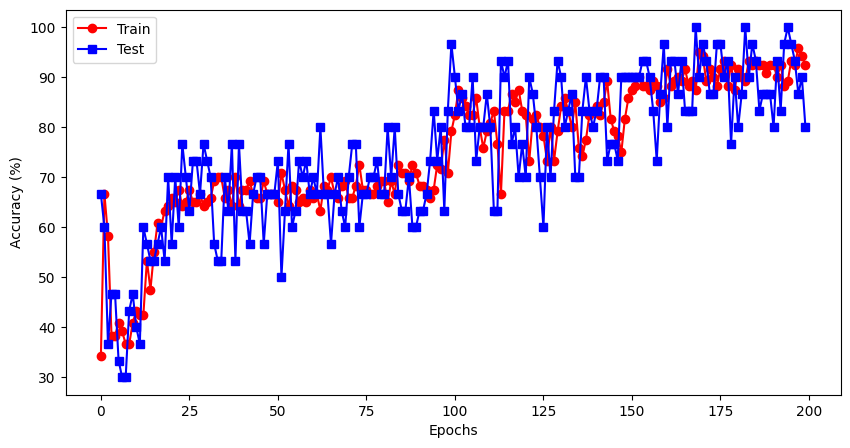

In [124]:
import matplotlib.pyplot as plt

# Create a model
model, criterion, optimizer = create_model()

# Train the model
train_accuracies, test_accuracies = train(0.8)

# Plot the results
fig = plt.figure(figsize=(10, 5))

plt.plot(train_accuracies, 'ro-')
plt.plot(test_accuracies, 'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train', 'Test'])
plt.show()

In [131]:
train_proportion_array = np.linspace(0.2, 0.95, 10)

train_accuracy_array = np.zeros((len(train_proportion_array), num_epochs))
test_accuracy_array = np.zeros((len(train_proportion_array), num_epochs))

for i in range(len(train_proportion_array)):
    # Create a model
    model, criterion, optimizer = create_model()

    # Train the model
    train_accuracies, test_accuracies = train(train_proportion_array[i])

    # Store the results
    train_accuracy_array[i, :] = train_accuracies
    test_accuracy_array[i, :] = test_accuracies

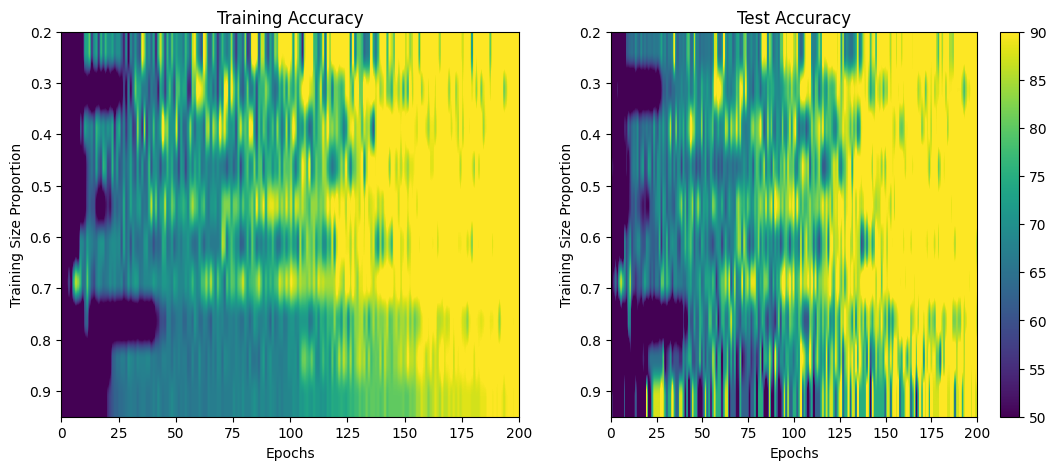

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].imshow(train_accuracy_array, aspect='auto', vmin=50, vmax=90, extent=[0, num_epochs, train_proportion_array[-1], train_proportion_array[0]])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training Size Proportion')
ax[0].set_title('Training Accuracy')

p = ax[1].imshow(test_accuracy_array, aspect='auto', vmin=50, vmax=90, extent=[0, num_epochs, train_proportion_array[-1], train_proportion_array[0]])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training Size Proportion')
ax[1].set_title('Test Accuracy')
fig.colorbar(p, ax=ax[1])

plt.show()

### 1-2-2. Cross Validation with Dataset & DataLoader

In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = \
                              train_test_split(data, labels, train_size=.8)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
train_loader = DataLoader(train_data,shuffle=True,batch_size=12)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# check sizes of data batches
for X,y in train_loader:
  print(X.shape,y.shape)

X,y

In [ ]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

  return ANNiris,lossfun,optimizer

In [ ]:
# train the model

# global parameter
numepochs = 500

def trainTheModel():

  # initialize accuracies as empties (not storing losses here)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):


    # loop over training data batches
    batchAcc = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...


    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

  # function output
  return trainAcc,testAcc

In [ ]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
trainAcc,testAcc = trainTheModel()

In [ ]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'ro-')
plt.plot(testAcc,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])

# optional zoom-in to final epochs
# plt.xlim([300,500])
# plt.ylim([90,100.5])

plt.show()

In [ ]:
# dataloader object with all data
fakedataLdr = DataLoader(fakedata, shuffle=True)
print( fakedataLdr )
print( fakedataLdr.batch_size )

In [ ]:
# iterate through the data
for i,oneSample in enumerate(fakedataLdr):
  print(i,oneSample,oneSample.shape)

# but where are the labels??

In [ ]:
# we need to create a Dataset that contains the data and labels
fakeDataset = torch.utils.data.TensorDataset(torch.Tensor(fakedata),torch.Tensor(fakelabels))
print( fakeDataset.tensors ), print(' ')

# then create another DataLoader
fakedataLdr = DataLoader(fakeDataset, shuffle=True)

# iterate through the data
for dat,lab in fakedataLdr:
  print(dat,lab)

In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(fakedata, fakelabels, test_size=.2)

# then convert them into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(
     torch.Tensor(train_data),torch.Tensor(train_labels))

test_data = torch.utils.data.TensorDataset(
     torch.Tensor(test_data),torch.Tensor(test_labels))

# finally, translate into dataloader objects
# notice the batches (see next cell)!
train_loader = DataLoader(train_data,batch_size=4)
test_loader  = DataLoader(test_data)

In [ ]:
# examine the contents of the dataloader (batching is an advantage of dataloader!)
print('TRAINING DATA')
for batch,label in train_loader: # iterable
  print(batch,label)
  print(' ')


print(' ')
print('TESTING DATA')
for batch,label in test_loader: # iterable
  print(batch,label)
  print(' ')

## 1-3. Custom Dataset

In [ ]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract only the first 8
labels = data[:8,0]
data   = data[:8,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# reshape to 2D!
dataNorm = dataNorm.reshape(dataNorm.shape[0],1,28,28)

# check sizes
print(dataNorm.shape)
print(labels.shape)

# convert to torch tensor format
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

In [ ]:
# My custom dataset class is modeled after the official class
??torch.utils.data.TensorDataset

In [ ]:
class customDataset(Dataset):
  def __init__(self, tensors, transform=None):

    # check that sizes of data and labels match
    assert all(tensors[0].size(0)==t.size(0) for t in tensors), "Size mismatch between tensors"
    
    # assign inputs
    self.tensors   = tensors
    self.transform = transform

  # what to do when someone wants and item from the dataset
  def __getitem__(self, index): 

    # return transformed version of x if there are transforms
    if self.transform:
      x = self.transform(self.tensors[0][index])
    else:
      x = self.tensors[0][index]

    # and return label
    y = self.tensors[1][index]

    return x,y # return the (data,label) tuple

  def __len__(self):
    return self.tensors[0].size(0)

In [ ]:
# Note: several transforms work only on PIL-format data, so it's common to transform
#       to PIL, apply transformations, then transform back to tensor.

# create a list of transforms to apply to the image
imgtrans = T.Compose([ 
                      T.ToPILImage(),
                      T.RandomVerticalFlip(p=.5),
                      # T.RandomRotation(90), 
                      T.ToTensor()
                       ])

In [ ]:
# now convert the data into datasets and then dataloaders

# convert into PyTorch Datasets
# NOTE: we have no test data here, but you should apply the same transformations to the test data
train_data = customDataset((dataT,labelsT),imgtrans)

# translate into dataloader objects
dataLoaded = DataLoader(train_data,batch_size=8,shuffle=False)

In [ ]:
type(train_data)

In [ ]:
# import data from the dataloader, just like during training
X,y = next(iter(dataLoaded))


# create a figure
fig,axs = plt.subplots(2,8,figsize=(16,4))


# loop over images in the dataset
for i in range(8):

  # draw images
  axs[0,i].imshow(dataT[i,0,:,:].detach(),cmap='gray')
  axs[1,i].imshow(X[i,0,:,:].detach(),cmap='gray')

  # some niceties
  for row in range(2):
    axs[row,i].set_xticks([])
    axs[row,i].set_yticks([])

# row labels
axs[0,0].set_ylabel('Original')
axs[1,0].set_ylabel('torch dataset')

plt.show()

In [ ]:
# Important to know: we haven't actually increased the amount of data
len(train_data)

# 2. Model Building
## 2-1. Sequential
The `torch.nn.Sequential` class is easy to set up & read but with limited flexibility & interactivity. Suitable for creating small models.  
1. `torch.nn.Sequential(*args: Module)`: Modules will be added to the sequential container in the order they are passed in the constructor.
2. `torch.nn.Sequential(arg: OrderedDict[str, Module])`: Passes in an `OrderedDict` of modules.

In [2]:
import torch

model = nn.Sequential(
    torch.nn.Conv2d(1, 20, 5),
    torch.nn.ReLU(),
    torch.nn.Conv2d(20, 64, 5),
    torch.nn.ReLU()
)
model

Sequential(
  (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(20, 64, kernel_size=(5, 5), stride=(1, 1))
  (3): ReLU()
)

In [5]:
from collections import OrderedDict

model = torch.nn.Sequential(OrderedDict([
    ("conv_1", torch.nn.Conv2d(1, 20, 5)),
    ("relu_1", torch.nn.ReLU()),
    ("conv_2", torch.nn.Conv2d(20, 64, 5)),
    ("relu_2", torch.nn.ReLU())
]))
model

Sequential(
  (conv_1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu_1): ReLU()
  (conv_2): Conv2d(20, 64, kernel_size=(5, 5), stride=(1, 1))
  (relu_2): ReLU()
)

## 2-2. Class
Your model should subclass `torch.nn.Module`. `torch.nn` holds basic build blocks for graphs.
1. `torch.nn.Module.parameters(recurse=True)`: Returns an iterator over module learnable parameters (weights & biases). This is typically passed to an optimizer.
2. `torch.nn.Module.named_parameters(prefix='', recurse=True, remove_duplicate=True)`: Returns an iterator over module parameters, yielding both the name of the parameter as well as the parameter itself.
3. `torch.nn.Module.to(device=None, dtype=None, non_blocking=False)`: Moves and/or casts the parameters and buffers.
4. `torch.nn.Module.load_state_dict(state_dict, strict=True, assign=False)`: Copies parameters and buffers from `state_dict` into this module and its descendants.
5. `torch.nn.Module.state_dict(*, destination: T_destination, prefix: str = '', keep_vars: bool = False)`: A Python dictionary object contains parameters & persistent buffers. 

In [14]:
class CNNModel(torch.nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv2d(1, 20, 5),
            torch.nn.ReLU(),
            torch.nn.Conv2d(20, 64, 5),
            torch.nn.ReLU()
        )
  
    def forward(self, X):
        out = self.conv_layers(X)
        return out

model = CNNModel()
model

CNNModel(
  (conv_layers): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
  )
)

In [17]:
# `parameters()`
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[[[ 1.3241e-01,  1.5604e-01, -1.0033e-01,  1.9216e-01, -6.9605e-02],
          [ 1.7387e-01, -8.7238e-02, -8.7400e-02, -6.6454e-03, -1.3710e-02],
          [ 4.7818e-02, -1.3161e-01, -1.2073e-01, -8.0846e-02, -1.4806e-01],
          [ 1.5466e-01,  1.7643e-01,  6.8757e-02, -1.3546e-01,  8.1396e-02],
          [ 1.4838e-01, -1.3129e-01, -3.4942e-02,  1.3256e-01,  1.8711e-01]]],


        [[[-1.7838e-01,  9.0442e-02,  9.4969e-02,  1.9040e-01, -5.6426e-02],
          [ 1.4222e-01,  1.0127e-01, -9.1116e-03, -2.4985e-02, -1.6505e-01],
          [ 1.7914e-01, -7.6648e-02, -1.7809e-01,  1.2110e-01, -5.1342e-02],
          [ 2.2690e-02,  1.5465e-01, -8.5308e-02, -4.7745e-02,  3.1571e-02],
          [ 2.8867e-02, -3.0587e-02, -3.1570e-02, -1.9829e-01, -4.0238e-02]]],


        [[[ 1.3186e-01, -1.4602e-01,  9.5862e-02, -8.8489e-02, -9.6553e-02],
          [-1.3332e-01,  1.1675e-02,  1.6270e-01,  1.4342e-01,  1.4186e-02],
          [ 6.7934e-02,  1.0176e-02,  5.6962e-

In [22]:
# `named_parameters()`
for name, param in model.named_parameters():
    print("Name:", name)
    print(param)

Name: conv_layers.0.weight
Parameter containing:
tensor([[[[ 1.3241e-01,  1.5604e-01, -1.0033e-01,  1.9216e-01, -6.9605e-02],
          [ 1.7387e-01, -8.7238e-02, -8.7400e-02, -6.6454e-03, -1.3710e-02],
          [ 4.7818e-02, -1.3161e-01, -1.2073e-01, -8.0846e-02, -1.4806e-01],
          [ 1.5466e-01,  1.7643e-01,  6.8757e-02, -1.3546e-01,  8.1396e-02],
          [ 1.4838e-01, -1.3129e-01, -3.4942e-02,  1.3256e-01,  1.8711e-01]]],


        [[[-1.7838e-01,  9.0442e-02,  9.4969e-02,  1.9040e-01, -5.6426e-02],
          [ 1.4222e-01,  1.0127e-01, -9.1116e-03, -2.4985e-02, -1.6505e-01],
          [ 1.7914e-01, -7.6648e-02, -1.7809e-01,  1.2110e-01, -5.1342e-02],
          [ 2.2690e-02,  1.5465e-01, -8.5308e-02, -4.7745e-02,  3.1571e-02],
          [ 2.8867e-02, -3.0587e-02, -3.1570e-02, -1.9829e-01, -4.0238e-02]]],


        [[[ 1.3186e-01, -1.4602e-01,  9.5862e-02, -8.8489e-02, -9.6553e-02],
          [-1.3332e-01,  1.1675e-02,  1.6270e-01,  1.4342e-01,  1.4186e-02],
          [ 6.7934e

In [23]:
# `named_parameters()` & `data` attribute
for name, param in model.named_parameters():
    print("Name:", name)
    print("Parameters:", param.data)

Name: conv_layers.0.weight
Parameters: tensor([[[[ 1.3241e-01,  1.5604e-01, -1.0033e-01,  1.9216e-01, -6.9605e-02],
          [ 1.7387e-01, -8.7238e-02, -8.7400e-02, -6.6454e-03, -1.3710e-02],
          [ 4.7818e-02, -1.3161e-01, -1.2073e-01, -8.0846e-02, -1.4806e-01],
          [ 1.5466e-01,  1.7643e-01,  6.8757e-02, -1.3546e-01,  8.1396e-02],
          [ 1.4838e-01, -1.3129e-01, -3.4942e-02,  1.3256e-01,  1.8711e-01]]],


        [[[-1.7838e-01,  9.0442e-02,  9.4969e-02,  1.9040e-01, -5.6426e-02],
          [ 1.4222e-01,  1.0127e-01, -9.1116e-03, -2.4985e-02, -1.6505e-01],
          [ 1.7914e-01, -7.6648e-02, -1.7809e-01,  1.2110e-01, -5.1342e-02],
          [ 2.2690e-02,  1.5465e-01, -8.5308e-02, -4.7745e-02,  3.1571e-02],
          [ 2.8867e-02, -3.0587e-02, -3.1570e-02, -1.9829e-01, -4.0238e-02]]],


        [[[ 1.3186e-01, -1.4602e-01,  9.5862e-02, -8.8489e-02, -9.6553e-02],
          [-1.3332e-01,  1.1675e-02,  1.6270e-01,  1.4342e-01,  1.4186e-02],
          [ 6.7934e-02,  1.01

In [25]:
# `state_dict()`
model.state_dict()

OrderedDict([('conv_layers.0.weight',
              tensor([[[[ 1.3241e-01,  1.5604e-01, -1.0033e-01,  1.9216e-01, -6.9605e-02],
                        [ 1.7387e-01, -8.7238e-02, -8.7400e-02, -6.6454e-03, -1.3710e-02],
                        [ 4.7818e-02, -1.3161e-01, -1.2073e-01, -8.0846e-02, -1.4806e-01],
                        [ 1.5466e-01,  1.7643e-01,  6.8757e-02, -1.3546e-01,  8.1396e-02],
                        [ 1.4838e-01, -1.3129e-01, -3.4942e-02,  1.3256e-01,  1.8711e-01]]],
              
              
                      [[[-1.7838e-01,  9.0442e-02,  9.4969e-02,  1.9040e-01, -5.6426e-02],
                        [ 1.4222e-01,  1.0127e-01, -9.1116e-03, -2.4985e-02, -1.6505e-01],
                        [ 1.7914e-01, -7.6648e-02, -1.7809e-01,  1.2110e-01, -5.1342e-02],
                        [ 2.2690e-02,  1.5465e-01, -8.5308e-02, -4.7745e-02,  3.1571e-02],
                        [ 2.8867e-02, -3.0587e-02, -3.1570e-02, -1.9829e-01, -4.0238e-02]]],
              
   

## 2-3. Activation Functions
- [Non-Linear Activations](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)

In [ ]:
# [1]
# import libraries
import torch
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':18})

In [ ]:
# variable to evaluate over
x = torch.linspace(-3,3,101)

# create a function that returns the activated output
def NNoutputx(actfun):
  # get activation function type
  # this code replaces torch.relu with torch.<actfun>
  actfun = getattr(torch,actfun)
  return actfun( x )

In [ ]:
# the activation functions
activation_funs = [ 'relu', 'sigmoid', 'tanh' ]

fig = plt.figure(figsize=(10,8))

for actfun in activation_funs:
  plt.plot(x,NNoutputx(actfun),label=actfun,linewidth=3)

# add reference lines
dashlinecol = [.7,.7,.7]
plt.plot(x[[0,-1]],[0,0],'--',color=dashlinecol)
plt.plot(x[[0,-1]],[1,1],'--',color=dashlinecol)
plt.plot([0,0],[-1,3],'--',color=dashlinecol)

# make the plot look nicer
plt.legend()
plt.xlabel('x')
plt.ylabel('$\sigma(x)$')
plt.title('Various activation functions')
plt.xlim(x[[0,-1]])
plt.ylim([-1,3])
plt.show()

In [ ]:
# create a function that returns the activated output FUNCTION
# this is different from the previous function
def NNoutput(actfun):
  # get activation function type
  # this code replaces torch.nn.relu with torch.nn.<actfun>
  actfun = getattr(torch.nn,actfun)
  return actfun()

In [ ]:
# the activation functions
activation_funs = [ 'ReLU6', 'Hardshrink', 'LeakyReLU' ]

fig = plt.figure(figsize=(10,8))

for actfun in activation_funs:
  plt.plot(x,NNoutput(actfun)(x),label=actfun,linewidth=3)

# add reference lines
dashlinecol = [.7,.7,.7]
plt.plot(x[[0,-1]],[0,0],'--',color=dashlinecol)
plt.plot(x[[0,-1]],[1,1],'--',color=dashlinecol)
plt.plot([0,0],[-1,3],'--',color=dashlinecol)

# make the plot look nicer
plt.legend()
plt.xlabel('x')
plt.ylabel('$\sigma(x)$')
plt.title('Various activation functions')
plt.xlim(x[[0,-1]])
plt.ylim([-1,3])
# plt.ylim([-.1,.1])
plt.show()

In [ ]:
# relu6 in more detail
x = torch.linspace(-3,9,101)
relu6 = torch.nn.ReLU6()

plt.plot(x,relu6(x))
plt.show()

In [ ]:
# redefine x (fewer points to facilitate visualization)
x = torch.linspace(-3,3,21)

# in torch
y1 = torch.relu(x)

# in torch.nn
f = torch.nn.ReLU()
y2 = f(x)


# the results are the same
plt.plot(x,y1,'ro',label='torch.relu')
plt.plot(x,y2,'bx',label='torch.nn.ReLU')
plt.legend()
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

In [ ]:
# create input vectors
x1 = torch.linspace(-1,1,20)
x2 = 2*x1

# and corresponding weights
w1 = -.3
w2 = .5

# their linear combination
linpart = x1*w1 + x2*w2

# and the nonlinear output
y = torch.relu(linpart)

# and plot!
plt.plot(x1,linpart,'bo-',label='Linear input')
plt.plot(x1,y,'rs',label='Nonlinear output')
plt.ylabel('$\\hat{y}$ (output of activation function)')
plt.xlabel('x1 variable')
# plt.ylim([-.1,.1]) # optional -- uncomment and modify to zoom in
plt.legend()
plt.show()

In [ ]:
# [2]
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

In [ ]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self,actfun):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

    # activation funcion to pass through
    self.actfun = actfun
  
  # forward pass
  def forward(self,x):
    # get activation function type
    # this code replaces torch.relu with torch.<self.actfun>
    actfun = getattr(torch,self.actfun)
    x = actfun( self.input(x) )
    x = actfun( self.fc1(x) )
    x = actfun( self.fc2(x) )
    return self.output(x)

In [ ]:
# test the model
# use sigmoid, relu, tanh
net = ANNwine('sigmoid')
net( torch.randn(10,11) ).shape

In [ ]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # turn on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses

In [ ]:
# this cell takes ~2 mins

# list activation functions to test
activation_funs = [ 'relu', 'tanh', 'sigmoid' ]

trainByAct = np.zeros((numepochs,len(activation_funs)))
testByAct  = np.zeros((numepochs,len(activation_funs)))

for ai,actfun in enumerate(activation_funs):
  # create a model and train it
  winenet = ANNwine(actfun)
  trainByAct[:,ai],testByAct[:,ai],losses = trainTheModel()


In [ ]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trainByAct)
ax[0].set_title('Train accuracy')
ax[1].plot(testByAct)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(activation_funs)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

plt.show()

## 2-4. Weight Initialization

In [ ]:
# build a model
aModel = nn.Sequential(
    nn.Linear(10,14),  # input layer
    nn.Linear(14,19),  # hidden layer
    nn.Linear(19,8),   # output layer
      )

aModel

In [ ]:
# print the sizes of the weights matrices in each layer
for i in range(len(aModel)):
  print( aModel[i].weight.shape )

In [ ]:
M2 = nn.Sequential(
    nn.Linear(10,14),  # input layer
    nn.Linear(14,9),   # hidden layer
    nn.Linear(19,8),   # output layer
      )

for i in range(len(M2)):
  print( M2[i].weight.shape )

In [ ]:
# generate the data
nsamples = 5
nfeatures = 10

fakedata = torch.randn(nsamples,nfeatures)

In [ ]:
# test the first model

# does the size of the output make sense?
aModel(fakedata).shape

In [ ]:
# test the second model

# does the size of the output make sense?
M2(fakedata).shape

In [ ]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [ ]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [ ]:
tmpnet = createTheMNISTNet()[0]
print(tmpnet)

print('\n\nWeights for layer fc1:')
print(tmpnet.fc1.weight.data)

In [ ]:
def function2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 10
  
  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch on train mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [ ]:
# Run the model without changing the weights; this will be the baseline performance.
# Notice the model creation is outside the function2train
net_base,lossfun,optimizer = createTheMNISTNet()
trainAcc_base,testAcc_base,losses,net_base = function2trainTheModel(net_base,lossfun,optimizer)

# plot the results
plt.plot(range(len(trainAcc_base)),trainAcc_base,'o-', range(len(testAcc_base)),testAcc_base ,'s-')
plt.legend(['Train','Test'])
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

In [ ]:
# Change the weights before training
net_zero,lossfun,optimizer = createTheMNISTNet()

# set to zeros
net_zero.fc1.weight.data = torch.zeros_like( net_zero.fc1.weight )

# confirm
net_zero.fc1.weight.data

In [ ]:
# run the model and show the results
trainAcc_zero,testAcc_zero,losses,net_zero = function2trainTheModel(net_zero,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_zero)),trainAcc_zero,'r-', range(len(testAcc_zero)),testAcc_zero ,'r:')
plt.legend(['Train base','Test base','Train fc1=zero','Test fc1=zero'])
plt.title('Accuracy comparison with layer FC1 init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

In [ ]:
# Are the weights still zeros?
print(net_zero.fc1.weight.data)

# show the distributions in a histogram
y,x = np.histogram(net_base.fc2.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(net_zero.fc2.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='FC1=zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

In [ ]:
# Change the weights before training
net_allzero,lossfun,optimizer = createTheMNISTNet()

# loop over parameters and set them all to zeros
for p in net_allzero.named_parameters():
  p[1].data = torch.zeros_like( p[1].data )


# and confirm for a few select parameters (y-axis offset for visibility)
plt.plot(0+net_allzero.fc1.weight.data.flatten(),'bo')
plt.plot(1+net_allzero.fc2.weight.data.flatten(),'rx')
plt.plot(2+net_allzero.fc1.bias.data.flatten(),'g^')
plt.xlabel('Parameter index')
plt.ylim([-1,3])
plt.ylabel('Parameter value')
plt.show()

In [ ]:
# run the model and show the results
trainAcc_allzero,testAcc_allzero,losses,net_allzero = function2trainTheModel(net_allzero,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allzero)),trainAcc_allzero,'r-', range(len(testAcc_allzero)),testAcc_allzero ,'r:')
plt.legend(['Train base','Test base','Train all zero','Test all zero'])
plt.title('Accuracy comparison with all layers init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

In [ ]:
# show the distributions in a histogram
y,x = np.histogram(net_base.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(net_allzero.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='All zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

In [ ]:
# woah, not even a single non-zero weight value?!?!!?!!??
plt.plot(net_allzero.fc1.weight.data.flatten(),'o');

In [ ]:
# Change the weights before training
net_allone,lossfun,optimizer = createTheMNISTNet()
for p in net_allone.named_parameters():
  p[1].data = torch.zeros_like( p[1].data ) + 1
  #p[1].data = torch.zeros( p[1].data.shape ) + 1 # equivalent to the previous line!


# run the model and show the results
trainAcc_allone,testAcc_allone,losses,net_allone = function2trainTheModel(net_allone,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allone)),trainAcc_allone,'r-', range(len(testAcc_allone)),testAcc_allone ,'r:')
plt.legend(['Train base','Test base','Train all ones','Test all ones'])
plt.title('Accuracy comparison with all layers init to ones')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

## 2-4-1. Kaiming Uniform Distribution
1. `torch.nn.init.kaiming_uniform_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu', generator=None)`: Fills the input `torch.Tensor` with values sampled from $\mathcal{U}(-bound, bound)$ where $bound=gain \times \sqrt{\frac{3}{fan\_mode}}$. `a` indicates the negative slope of the rectifier, `leaky_relu`, used after this layer. `mode` is either `fan_in`, preserving the magnitude of the variance of the weights in the forward pass, or `fan_out`, preserving the magnitudes in the backwards pass. `nonlinearity` is the `torch.nn.functional` name, recommended to use only with `relu` or `leaky_relu`. 
    - Take `torch.nn.Linear` with `torch.nn.functional.leaky_relu` for example, it intializes weights using `torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))` so that $negative\_slope$ is $5$. The $gain$ is $\sqrt{\frac{2}{1+negative\_slope^{2}}}=\sqrt{\frac{2}{1+5}}=\frac{1}{\sqrt{3}}$, and the $bound$ is $\frac{1}{\sqrt{3}} \times \sqrt{\frac{3}{fan\_in}} = \frac{1}{\sqrt{fan\_in}}$. Therefore, the learnable weights are initialized from $\mathcal{U}(-\sqrt{k}, \sqrt{k})$ where $k=\frac{1}{in\_features}=\frac{1}{fan\_in}=bound^{2}$.

In [ ]:
# 
# create a class for the model
class thenet(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(100,100)
    
    ### hidden layer
    self.fc1 = nn.Linear(100,100)
    self.fc2 = nn.Linear(100,100)
    self.fc3 = nn.Linear(100,100)

    ### output layer
    self.output = nn.Linear(100,2)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    x = F.relu( self.fc3(x) )
    return self.output(x)

In [ ]:
# create an instance of the model
net = thenet()
print(net)

In [ ]:
# collect all weights and biases
allweight = np.array([])
allbiases = np.array([])

for p in net.named_parameters():
  if 'bias' in p[0]:
    allbiases = np.concatenate( (allbiases,p[1].data.numpy().flatten()),axis=0 )
  elif 'weight' in p[0]:
    allweight = np.concatenate( (allweight,p[1].data.numpy().flatten()),axis=0 )


# how many are there?
print(f'There are {len(allbiases)} bias parameters.')
print(f'There are {len(allweight)} weight parameters.')


# show their histograms
fig,ax = plt.subplots(1,3,figsize=(18,4))

ax[0].hist(allbiases,40)
ax[0].set_title('Histogram of initial biases')


ax[1].hist(allweight,40)
ax[1].set_title('Histogram of initial weights')



# collect histogram data to show as line plots
yB,xB = np.histogram(allbiases,30)
yW,xW = np.histogram(allweight,30)

ax[2].plot((xB[1:]+xB[:-1])/2,yB/np.sum(yB),label='Bias')
ax[2].plot((xW[1:]+xW[:-1])/2,yW/np.sum(yW),label='Weight')
ax[2].set_title('Density estimate for both')
ax[2].legend()


# plot adjustments common to all subplots
for i in range(3):
  ax[i].set_xlabel('Initial value')
  ax[i].set_ylabel('Count')
ax[2].set_ylabel('Probability')

plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,4))

for p in net.named_parameters():

  # get the data and compute their histogram
  thesedata = p[1].data.numpy().flatten()
  y,x = np.histogram(thesedata,10)

  # for the bias
  if 'bias' in p[0]:
    ax[0].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s bias (N=%g)'%(p[0][:-5],len(thesedata)))

  # for the weights
  elif 'weight' in p[0]:
    ax[1].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s weight (N=%g)'%(p[0][:-7],len(thesedata)))



ax[0].set_title('Biases per layer')
ax[0].legend()
ax[1].set_title('Weights per layer')
ax[1].legend(bbox_to_anchor=(1,1),loc='upper left')
plt.show()

In [ ]:
# What's up with the weird output bias distribution??
print( net.output.bias.data )

In [ ]:
# Check out the docstring for linear layers
nn.Linear?

In [ ]:
# Let's test whether the numbers match our prediction from the formula

# empirical bias range
biasrange = [ torch.min(net.fc1.bias.data).item(), torch.max(net.fc1.bias.data).item() ]
biascount = len(net.fc1.bias.data)

# theoretical expected value
sigma = np.sqrt(1/biascount)

# drum rolllllll.....
print('Theoretical sigma = ' + str(sigma))
print('Empirical range = ' + str(biasrange))

## 2-4-2. Xavier Normal Distribution

In [ ]:
# create a new instance of the model
net = thenet()

# change the weights (leave biases as Kaiming [default])
for p in net.named_parameters():
  if 'weight' in p[0]:
    nn.init.xavier_normal_(p[1].data)

In [ ]:
# Scroll up and re-run the previous weights visualization cells with the new network.
# Then continue below.

In [ ]:
# Let's test whether the numbers match our prediction from the formula

# empirical weight standard deviation
weightvar   = torch.var(net.fc1.weight.data.flatten()).item()
weightcount = len(net.fc1.weight.data)

# theoretical expected value
sigma2 = 2 / (weightcount+weightcount)

# drum rolllllll.....
print('Theoretical sigma = ' + str(sigma2))
print('Empirical variance = ' + str(weightvar))

## 2-5. Summary
- [torchinfo](https://github.com/TylerYep/torchinfo)

In [28]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       520
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       32,064
│    └─ReLU: 2-4                         --
Total params: 32,584
Trainable params: 32,584
Non-trainable params: 0

In [29]:
summary(model, input_size=(32, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [32, 64, 20, 20]          --
├─Sequential: 1-1                        [32, 64, 20, 20]          --
│    └─Conv2d: 2-1                       [32, 20, 24, 24]          520
│    └─ReLU: 2-2                         [32, 20, 24, 24]          --
│    └─Conv2d: 2-3                       [32, 64, 20, 20]          32,064
│    └─ReLU: 2-4                         [32, 64, 20, 20]          --
Total params: 32,584
Trainable params: 32,584
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 420.00
Input size (MB): 0.10
Forward/backward pass size (MB): 9.50
Params size (MB): 0.13
Estimated Total Size (MB): 9.73

# 3. Training
## 3-1. Loss Functions
1. Each PyTorch Loss function creates a criterion that measures the loss between `output` from a model and `target`, returning a `torch.Tensor`.
   - [Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)
   - Metrics supporting backpropagation (`is_differentiable == True`) in **TorchMetrics** can be used. More details in [Metrics & Differentiability](https://lightning.ai/docs/torchmetrics/stable/pages/overview.html#metrics-and-differentiability).
2. `torch.Tensor.backward(gradient=None, retain_graph=None, create_graph=False, inputs=None)`: Computes the gradient of current tensor with reference to graph leaves. The graph is differentiated using the chain rule. This function accumulates gradients in the leaves.

In [10]:
import torch, torch.nn as nn

loss = nn.MSELoss()
# Model output
input = torch.randn(3, 5, requires_grad=True)
print(input)
target = torch.randn(3, 5)
print(target)
output = loss(input, target)
print(output)
output.backward()
print(input.grad)

tensor([[-0.6368,  0.6902, -1.1642,  1.7340,  0.3089],
        [-0.5741, -2.2496,  0.1549,  0.2255, -0.5959],
        [ 0.6467,  0.2575,  1.8013,  0.4424, -0.4409]], requires_grad=True)
tensor([[-0.7584,  0.2138, -0.3933,  0.1054,  0.2149],
        [ 0.2793,  0.7960, -0.1902,  2.1231, -0.5180],
        [ 1.6648, -0.5898,  2.1185,  0.5762,  1.2281]])
tensor(1.4591, grad_fn=<MseLossBackward0>)
tensor([[ 0.0162,  0.0635, -0.1028,  0.2171,  0.0125],
        [-0.1138, -0.4061,  0.0460, -0.2530, -0.0104],
        [-0.1358,  0.1130, -0.0423, -0.0178, -0.2225]])


In [ ]:
# Mean-squared error
# loss function
lossfunMSE = nn.MSELoss()

# create predictions and real answer
yHat = torch.linspace(-2,2,101)
y = torch.tensor(.5)

# compute MSE loss function
L = np.zeros(101)
for i,yy in enumerate(yHat):
  L[i] = lossfunMSE(yy,y)

plt.plot(yHat,L,label='Loss')
plt.plot([y,y],[0,np.max(L)],'r--',label='True value')
plt.xlabel('Predicted value')
plt.legend()
plt.show()


In [ ]:
# Binary cross-entropy
# loss function
lossfunBCE = nn.BCELoss()

# create predictions and real answer
yHat = torch.linspace(.001,.999,101)
y1 = torch.tensor(0.)
y2 = torch.tensor(1.)

# compute MSE loss function
L = np.zeros((101,2))
for i,yy in enumerate(yHat):
  L[i,0] = lossfunBCE(yy,y1) # 0 is the correct answer
  L[i,1] = lossfunBCE(yy,y2) # 1 is the correct answer

plt.plot(yHat,L)
plt.xlabel('Predicted value')
plt.ylabel('Loss')
plt.legend(['correct=0','correct=1'])
# plt.yscale('log')
plt.show()

In [ ]:
# The example above shows data already in probabilities. Raw outputs will need to be converted to probabilities:

# "raw" output of a model
yHat = torch.tensor(2.)
print(lossfunBCE(yHat,y2))

# convert to prob via sigmoid
sig = nn.Sigmoid()
print(lossfunBCE( sig(yHat) ,y2))

In [ ]:
# However, PyTorch recommends using a single function that incorporates sigmoid+BCE due to increased numerical stability.
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html?highlight=nn%20bcewithlogitsloss#torch.nn.BCEWithLogitsLoss


# Thus, the recommended way to do it:
lossfunBCE = nn.BCEWithLogitsLoss()
yHat = torch.tensor(2.)
print(lossfunBCE(yHat,y2))

# In toy examples, numerical accuracy usually isn't a problem.

In [ ]:
# Categorical cross-entropy
# loss function
lossfunCCE = nn.CrossEntropyLoss()

# vector of output layer (pre-softmax)
yHat = torch.tensor([[1.,4,3]])

for i in range(3):
  correctAnswer = torch.tensor([i])
  thisloss = lossfunCCE(yHat,correctAnswer).item()
  print( 'Loss when correct answer is %g: %g' %(i,thisloss) )

In [ ]:
# Repeat using pre-softmaxified output
sm = nn.Softmax(dim=1)
yHat_sm = sm(yHat)

for i in range(3):
  correctAnswer = torch.tensor([i])
  thisloss = lossfunCCE(yHat_sm,correctAnswer).item()
  print( 'Loss when correct answer is %g: %g' %(i,thisloss) )

In [ ]:
# compare raw, softmax, and log-softmax outputs
sm = nn.LogSoftmax(dim=1)
yHat_logsm = sm(yHat)

# print them
print(yHat)
print(yHat_sm)
print(yHat_logsm)

In [ ]:
# Custom loss functions
class myLoss(nn.Module): # inherent info from nn.Module
  def __init__(self):
    super().__init__()
      
  def forward(self,x,y):
    loss = torch.abs(x-y)
    return loss

# test it out!
lfun = myLoss()
lfun(torch.tensor(4),torch.tensor(5.2))

## 3-2. Optimizer
1. `torch.optim` implements various [Optimization Algorithms](https://pytorch.org/docs/stable/optim.html#algorithms).
2. `torch.optim.Optimizer.step(closure=None)`: Performs a single optimization step (parameter update).
    - For example, [torch.optim.SGD.step(closure=None)](https://github.com/pytorch/pytorch/blob/cd9b27231b51633e76e28b6a34002ab83b0660fc/torch/optim/sgd.py#L63).
3. `torch.optim.Optimizer.zero_grad(set_to_none=True)`: Resets the gradients of all optimized `torch.Tensor`s.
4. `torch.optim.Optimizer.load_state_dict(state_dict)`: Loads the optimizer state. Uses this function when loading a general checkpoint for inference or resuming training.
5. `torch.optim.Optimizer.state_dict`: Contains information about the optimizer's state (parameters to be optimized), as well as the hyperparameters used.
6. `torch.optim.Optimizer.add_param_group(param_group)`: Adds a param group to the `Optimizer`'s `param_groups`. Uses this function when fine tuning a pre-trained network as frozen layers can be made trainable and added to the `Optimizer` as training progresses.

In [ ]:
# [1] Momentum
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
print(f'There are {len(train_loader)} batches, each with {batchsize} samples.')

In [ ]:
# create a class for the model
def createTheQwertyNet(momentum):

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)
      
      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)
  
  # create the model instance
  net = qwertyNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer (note extra input!)
  optimizer = torch.optim.SGD(net.parameters(),lr=.01,momentum=momentum)

  return net,lossfun,optimizer

In [ ]:
# confirm that the optimizer has momentum
optim = createTheQwertyNet(.9)[2]
optim

In [ ]:
# a function that trains the model


# number of epochs
numepochs = 50


def function2trainTheModel(momentum):
  
  # create a new model
  net,lossfun,optimizer = createTheQwertyNet(momentum)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) ) 
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [ ]:
# momentum values to use
momenta = [0,.5,.9,.95,.999]

# initialize results matrix
results = np.zeros((numepochs,len(momenta),3))

# test all momentum values on the same data (different model instances)
for idx,mom in enumerate(momenta):
  trainAcc,testAcc,losses,net = function2trainTheModel(mom)
  results[:,idx,0] = losses
  results[:,idx,1] = trainAcc
  results[:,idx,2] = testAcc

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(16,5))

for i in range(3):
  ax[i].plot(results[:,:,i])
  ax[i].legend(momenta)
  ax[i].set_xlabel('Epochs')
  if i==0:
    ax[i].set_ylabel('Loss')
  else:
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([20,100])

ax[0].set_title('Losses')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()

In [ ]:
# [2] Comparison
# create a class for the model
def createTheQwertyNet(optimizerAlgo):

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)
      
      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)
  
  # create the model instance
  net = qwertyNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optifun = getattr( torch.optim,optimizerAlgo )
  optimizer = optifun(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [ ]:
# test the model with optimizer type as input

# try 'SGD', 'RMSprop', and 'Adam'
optim = createTheQwertyNet('RMSprop')[2]
optim

In [ ]:
def function2trainTheModel(optimizerType):

  # number of epochs
  numepochs = 50
  
  # create a new model
  net,lossfun,optimizer = createTheQwertyNet(optimizerType)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) ) 
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [ ]:
# a function that plots the results
def plotTheResults(optimizerType):

  # compute accuracy over entire dataset (train+test)
  yHat = net(data)
  predictions = torch.argmax(yHat,axis=1)
  accuracy = (predictions == labels).float()
  totalAcc = torch.mean(100*accuracy).item()

  # and accuracy by group
  accuracyByGroup = np.zeros(3)
  for i in range(3):
    accuracyByGroup[i] = 100*torch.mean(accuracy[labels==i])


  # create the figure
  fig,ax = plt.subplots(2,2,figsize=(10,6))

  # plot the loss function
  ax[0,0].plot(losses.detach())
  ax[0,0].set_ylabel('Loss')
  ax[0,0].set_xlabel('epoch')
  ax[0,0].set_title(f'{optimizerType}: Losses')

  # plot the accuracy functions
  ax[0,1].plot(trainAcc,label='Train')
  ax[0,1].plot(testAcc,label='Test')
  ax[0,1].set_ylabel('Accuracy (%)')
  ax[0,1].set_xlabel('Epoch')
  ax[0,1].set_title(f'{optimizerType}: Accuracy')
  ax[0,1].legend()

  # plot overall accuracy by group
  ax[1,0].bar(range(3),accuracyByGroup)
  ax[1,0].set_ylim([np.min(accuracyByGroup)-5,np.max(accuracyByGroup)+5])
  ax[1,0].set_xticks([0,1,2])
  ax[1,0].set_xlabel('Group')
  ax[1,0].set_ylabel('Accuracy (%)')
  ax[1,0].set_title(f'{optimizerType}: Accuracy by group')

  # scatterplot of correct and incorrect labeled data
  colorShapes = [ 'bs','ko','g^' ] # data markers
  for i in range(3):
    # plot all data points
    ax[1,1].plot(data[labels==i,0],data[labels==i,1],colorShapes[i],
                 alpha=.3,label=f'Group {i}')
    
    # cross-out the incorrect ones
    idxErr = (accuracy==0) & (labels==i)
    ax[1,1].plot(data[idxErr,0],data[idxErr,1],'rx')

  ax[1,1].set_title(f'{optimizerType}: Total accuracy: {totalAcc:.2f}%')
  ax[1,1].set_xlabel('qwerty dimension 1')
  ax[1,1].set_ylabel('qwerty dimension 2')
  ax[1,1].legend()
  
  plt.tight_layout()
  plt.show()

In [ ]:
# run the model for one optimizer
optimizerType = 'Adam'
trainAcc,testAcc,losses,net = function2trainTheModel(optimizerType)

# visualize!
plotTheResults(optimizerType)

In [ ]:
# now run through all of them

# average performance
performance = []

for opto in ['SGD','RMSprop','Adam']:
  trainAcc,testAcc,losses,net = function2trainTheModel(opto)
  plotTheResults(opto)

  # store the final results
  train = np.mean(trainAcc[-10:])
  test  = np.mean(testAcc[-10:])

  performance.append( f'{opto}: train {train:.1f}%, test {test:.1f}%' )
    
print(performance)

In [ ]:
# [3] Learning rate decay
# create a class for the model
def createTheQwertyNet(initialLR):

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)
      
      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)
  
  # create the model instance
  net = qwertyNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer and LR scheduler
  optimizer = torch.optim.SGD(net.parameters(),lr=initialLR)
  stepsize  = batchsize*len(train_loader)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=stepsize,gamma=.5)

  return net,lossfun,optimizer,scheduler

In [ ]:
# how many steps until the learning rate changes?
len(train_loader)*batchsize

In [ ]:
# create a network
net = createTheQwertyNet(.01)[0]

# a new optimizer
optimizer = torch.optim.SGD(net.parameters(),lr=.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=1/2)

# test the change in learning rate
for epoch in range(3):
  for batchnum in range(10):
    print(f'Batch {batchnum}, epoch {epoch}: LR={scheduler.get_last_lr()[0]}')
    scheduler.step()

In [ ]:
# a function that trains the model

def function2trainTheModel(initialLR,toggleDynamicLR):

  # number of epochs
  numepochs = 50
  
  # create a new model
  net,lossfun,optimizer,scheduler = createTheQwertyNet(initialLR)

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []
  currentLR = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # step the learning-rate scheduler
      if toggleDynamicLR:
        scheduler.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
      batchAcc.append( accuracyPct )               # add to list of accuracies

      currentLR.append( scheduler.get_last_lr()[0] )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net,currentLR

In [ ]:
# test that the learning rate is really working
trainAcc,testAcc,losses,net,currentLR = function2trainTheModel(.01,True)
plt.plot(currentLR)
plt.title('Learning rate should change')
plt.show()

trainAcc,testAcc,losses,net,currentLR = function2trainTheModel(.01,False)
plt.plot(currentLR)
plt.title('Learning rate should stay fixed')
plt.show()

In [ ]:
# now test with and without dynamic LR
trainAccDynamic,testAccDynamic,losses,net,currentLR = function2trainTheModel(.01,True)
trainAccStatic,testAccStatic,losses,net,currentLR   = function2trainTheModel(.01,False)

fig = plt.figure(figsize=(8,5))
plt.plot(trainAccDynamic,'r',label='Dyn: Train')
plt.plot(testAccDynamic,'r--',label='Dyn: Test')

plt.plot(trainAccStatic,'b',label='Stat: Train')
plt.plot(testAccStatic,'b--',label='Stat: Test')

plt.xlabel('Training epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

## 3-3. Mini-Batch Gradient Descent

In [ ]:
# [1]
# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

In [ ]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [ ]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??

In [ ]:
# check sizes of data batches
for X,y in train_loader:
  print(X.shape,y.shape)

# go back and set drop_last=True in training DataLoader

In [ ]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.0005)

  return ANNiris,lossfun,optimizer

In [ ]:
# train the model

# global parameter
numepochs = 2500

def trainTheModel():

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

In [ ]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
trainAcc,testAcc,losses = trainTheModel()

In [ ]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with minibatch size=' + str(batchsize))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with minibatch size=' + str(batchsize))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([27,103])

plt.show()

In [ ]:
# [2] Normalization
# # z-score the data
# import scipy.stats as stats
# cols2zscore = iris.keys()
# cols2zscore = cols2zscore.drop('species')
# iris[cols2zscore] = iris[cols2zscore].apply(stats.zscore)

# iris.plot(marker='o',linestyle='none',figsize=(12,6))
# plt.xlabel('Sample number')
# plt.ylabel('Value')
# plt.show()

In [ ]:
# [3]
# create data

nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3 ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
train_batchsize = 16
test_batchsize  = test_data.tensors[0].shape[0]-2
train_loader = DataLoader(train_data,batch_size=train_batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_batchsize)

In [ ]:
# check sizes of data batches
for X,y in test_loader:
  print(X.shape,y.shape)

In [ ]:
class theModelClass(nn.Module):
  def __init__(self):
    super().__init__()

    ### layers
    self.input  = nn.Linear(  2,128)
    self.hidden = nn.Linear(128,128)
    self.output = nn.Linear(128, 1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.hidden(x) )
    x = self.output(x)
    return x

In [ ]:
# a function that creates the ANN model

def createANewModel():

  # grab an instance of the model class
  ANNQC = theModelClass()

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNQC.parameters(),lr=.01)

  return ANNQC,lossfun,optimizer

In [ ]:
# train the model

# global parameter
numepochs = 500

# NOTE: this time, the model, lossfun, and optimizer are inputs into the function!
def trainTheModel(ANNQC,lossfun,optimizer):

  # initialize accuracies as empties (not storing losses here)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNQC(X)
      loss = lossfun(yHat,y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # test accuracy (NOTE: testing in batches!)
    tstacc = []
    for X,y in test_loader:
      yHat = ANNQC(X)
      tstacc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # now get the average accuracy over test-batches
    testAcc.append(np.mean(tstacc))
  
  # function output
  return trainAcc,testAcc


In [ ]:
# create a model
ANNQC,lossfun,optimizer = createANewModel()

# train the model (note the inputs!)
trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)

In [ ]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'bs')
plt.plot(testAcc,'ro')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])

plt.show()

## 3-4. Weight Characteristics

In [ ]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [ ]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer (Note: SGD to slow down learning!)
  optimizer = torch.optim.SGD(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
def function2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 60
  
  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  # initialize weight change matrices
  weightChange = np.zeros((numepochs,4))
  weightConds  = np.zeros((numepochs,4))

  # loop over epochs
  for epochi in range(numepochs):

    # store the weights for each layer
    preW = []
    for p in net.named_parameters():
      if 'weight' in p[0]:
        preW.append( copy.deepcopy(p[1].data.numpy()) )


    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )


    # finally, get the post-learning state of the weights
    for (i,p) in enumerate(net.named_parameters()):
      if 'weight' in p[0]:
        # condition number
        weightConds[epochi,int(i/2)]  = np.linalg.cond(p[1].data)

        # Frobenius norm of the weight change from pre-learning
        weightChange[epochi,int(i/2)] = np.linalg.norm( preW[int(i/2)]-p[1].data.numpy(), ord='fro')

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net,weightChange,weightConds,preW

In [ ]:
# create the network
net,lossfun,optimizer = createTheMNISTNet()

# train the model
trainAcc,testAcc,losses,net,weightChange,weightConds,preW = function2trainTheModel(net,lossfun,optimizer)

In [ ]:
# Show the results!

# get a list of layer names
layername = []
for (i,p) in enumerate(net.named_parameters()):
  if 'weight' in p[0]:
    layername.append(p[0][:-7])


# set up the plot
fig,ax = plt.subplots(1,3,figsize=(16,3))

# accuracy
ax[0].plot(trainAcc)
ax[0].plot(testAcc)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Accuracy')
ax[0].legend(['Train','Test'])

# weight changes
ax[1].plot(weightChange)
ax[1].set_xlabel('Epochs')
ax[1].set_title('Weight change from previous epoch')
ax[1].legend(layername)

# weight condition numbers
ax[2].plot(weightConds)
ax[2].set_xlabel('Epochs')
ax[2].set_title('Condition number')
ax[2].legend(layername)
ax[2].set_ylim([0,20])

plt.show()

In [ ]:
# final inspection: check the derivative of accuracy against the weight change
from scipy.stats import zscore # normalize for scaling offsets

plt.plot(zscore(np.diff(trainAcc)),label='d(trainAcc)')
plt.plot(zscore(np.mean(weightChange,axis=1)),label='Weight change')
plt.legend()
plt.title('Change in weights by change in accuracy')
plt.xlabel('Epoch')
plt.show()

## 3-5. Gradient Accumulation

**Gradient Accumulation** refers to the situation, where multiple backwards passes are performed before updating the parameters. The goal is to have the same model parameters for multiple inputs (batches) and then update the model's parameters based on all these batches, instead of performing an update after every single batch. This technique is used to overcome GPU memory limitations when training neural networks. 

Gradient accumulation adds gradients over an effective batch of size, `batch_per_iter * iters_to_accumulate` (`* num_procs` if distributed). Steps including:
- Specify the `iters_to_accumulate` parameter, indicating how many batches we would like to update the network weights.
- Condition the weight update on the index of the running batch. This requires using `enumerate(DataLoader)` to store the batch index when looping through the data.
- Divide the running loss by `iters_to_accumulate`. This normalizes the loss to reduce the contribution of each mini-batch we are actually processing. Depending on the way you compute the loss, you might not need this step. If you average loss within each batch, the division is already correct and there is no need for extra normalization.

In [ ]:
optimizer = ...

for epoch in range(...):
    # loop through batches
    for inputs, labels in data_loader:
        # extract inputs and labels
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        # passes and weights update
        with torch.set_grad_enabled(True):
            # forward pass
            preds = model(inputs)
            loss = criterion(preds, labels)
    
            # backward pass
            loss.backward()
    
            # weights update
            optimizer.step()
            optimizer.zero_grad()

In [ ]:
# batch accumulation parameter
iters_to_accumulate = 4
optimizer = ...

for epoch in range(...):
    # loop through enumaretad batches
    for batch_idx, (inputs, labels) in enumerate(data_loader):
        # extract inputs and labels
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        # passes and weights update
        with torch.set_grad_enabled(True):
            # forward pass
            preds = model(inputs)
            loss = criterion(preds, labels)
    
            # normalize loss to account for batch accumulation
            loss = loss / iters_to_accumulate
    
            # backward pass
            loss.backward()
    
            # weights update
            if ((batch_idx + 1) % iters_to_accumulate == 0) or (batch_idx + 1 == len(data_loader)):
                optimizer.step()
                optimizer.zero_grad()

## 3-6. Automatic Mixed Precision

NVIDIA researchers created a methodology that combines single precision with the half precision floating point numbers for training deep learning models, that achieves the same level of accuracy as `float32`. Main advantages include less training time, enabling larger batch sizes, larger models & inputs, lower memory requirements. 

In PyTorch, **Automatic Mixed Precision Training** means training with `torch.autocast` & `torch.amp.GradScaler` together.
- Instances of `torch.autocast` enable autocasting for chosen regions. Autocasting automatically chooses the precision for GPU operations to improve performance while maintaining accuracy.
- Instances of `torch.amp.GradScaler` help perform the steps of gradient scaling conveniently. Gradient scaling improves convergence for networks with `float16` gradients by minimizing gradient underflow.

In [ ]:
import torch
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

for epoch in range(epochs):
    for input, target in data:
        optimizer.zero_grad()

        with autocast(device_type='cuda', dtype=torch.float16):
            output = model(input)
            loss = loss_fn(output, target)
		
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

In [ ]:
import torch
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()
batch_size = 4
iters_to_accumulate = 16
# this means training will be done for affective batch size of 4 * 16 = 64

for epoch in range(epochs):
    for batch_idx, (input, target) in enumerate(data):
        with autocast(device_type='cuda', dtype=torch.float16):
            output = model(input)
            loss = loss_fn(output, target)
            loss = loss / iters_to_accumulate

        scaler.scale(loss).backward()

        if (batch_idx + 1) % iters_to_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

# 4. Evaluation
## 4-1. Accuracy, Precision, Recall & F-Score

In [ ]:
## run experiment

# number of 'trials' in the experiment
N = 50 # actual trials is 2N

# number of experiment repetitions
numExps = 10000

# initialize
accuracy  = np.zeros(numExps)
precision = np.zeros(numExps)
recall    = np.zeros(numExps)
F1score   = np.zeros(numExps)


### run the experiment!
for expi in range(numExps):
    
  # generate data
  TP = np.random.randint(1,N)  # true positives,  aka hits
  FN = N-TP                    # false negatives, aka misses
  TN = np.random.randint(1,N)  # true negatives,  aka correct rejections
  FP = N-TN                    # false positives, aka false alarms
  

  ### the four performance measures discussed in lecture

  # accuracy
  accuracy[expi]  = (TP+TN) / (2*N)

  # precision
  precision[expi] = TP / (TP+FP)

  # recall
  recall[expi]    = TP / (TP+FN)

  # Fscore
  F1score[expi]   = TP / (TP+(FP+FN)/2)

In [ ]:
## let's see how they relate to each other!

fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].scatter(accuracy,F1score,s=5,c=precision)
ax[0].plot([0,1],[.5,.5],'k--',linewidth=.5)
ax[0].plot([.5,.5],[0,1],'k--',linewidth=.5)
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('F1-score')
ax[0].set_title('F1-Accuracy by precision')


ax[1].scatter(accuracy,F1score,s=5,c=recall)
ax[1].plot([0,1],[.5,.5],'k--',linewidth=.5)
ax[1].plot([.5,.5],[0,1],'k--',linewidth=.5)
ax[1].set_xlabel('Accuracy')
ax[1].set_ylabel('F1-score')
ax[1].set_title('F1-Accuracy by recall')

plt.show()

In [ ]:
# [2] Wine quality
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

In [ ]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, create dataloaders
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

In [ ]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)
  
  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

In [ ]:
# global parameter
numepochs = 1000

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses

In [ ]:
# create and train a model
winenet = ANNwine()
trainAcc,testAcc,losses = trainTheModel()

In [ ]:
# predictions for training data
train_predictions = winenet(train_loader.dataset.tensors[0])
train_predictions

# predictions for test data
test_predictions = winenet(test_loader.dataset.tensors[0])
test_predictions

In [ ]:
# NEW! using scikitlearn to compute ARPF
import sklearn.metrics as skm

# initialize vectors
train_metrics = [0,0,0,0]
test_metrics  = [0,0,0,0]

# training
train_metrics[0] = skm.accuracy_score (train_loader.dataset.tensors[1],train_predictions>0)
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1],train_predictions>0)
train_metrics[2] = skm.recall_score   (train_loader.dataset.tensors[1],train_predictions>0)
train_metrics[3] = skm.f1_score       (train_loader.dataset.tensors[1],train_predictions>0)


# test
test_metrics[0] = skm.accuracy_score (test_loader.dataset.tensors[1],test_predictions>0)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1],test_predictions>0)
test_metrics[2] = skm.recall_score   (test_loader.dataset.tensors[1],test_predictions>0)
test_metrics[3] = skm.f1_score       (test_loader.dataset.tensors[1],test_predictions>0)

In [ ]:
plt.bar(np.arange(4)-.1,train_metrics,.5)
plt.bar(np.arange(4)+.1,test_metrics,.5)
plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
plt.ylim([.6,1])
plt.legend(['Train','Test'])
plt.title('Performance metrics')
plt.show()

In [ ]:
# Confusion matrices
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1],train_predictions>0)
testConf  = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions>0)

fig,ax = plt.subplots(1,2,figsize=(10,4))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',vmax=len(train_predictions)/2)
ax[0].set_xticks([0,1])
ax[0].set_yticks([0,1])
ax[0].set_xticklabels(['bad','good'])
ax[0].set_yticklabels(['bad','good'])
ax[0].set_xlabel('Predicted quality')
ax[0].set_ylabel('True quality')
ax[0].set_title('TRAIN confusion matrix')

# add text labels
ax[0].text(0,0,f'True negatives:\n{trainConf[0,0]}' ,ha='center',va='center')
ax[0].text(0,1,f'False negatives:\n{trainConf[1,0]}',ha='center',va='center')
ax[0].text(1,1,f'True positives:\n{trainConf[1,1]}' ,ha='center',va='center')
ax[0].text(1,0,f'False positives:\n{trainConf[0,1]}',ha='center',va='center')




# confmat during TEST
ax[1].imshow(testConf,'Blues',vmax=len(test_predictions)/2)
ax[1].set_xticks([0,1])
ax[1].set_yticks([0,1])
ax[1].set_xticklabels(['bad','good'])
ax[1].set_yticklabels(['bad','good'])
ax[1].set_xlabel('Predicted quality')
ax[1].set_ylabel('True quality')
ax[1].set_title('TEST confusion matrix')

# add text labels
ax[1].text(0,0,f'True negatives:\n{testConf[0,0]}' ,ha='center',va='center')
ax[1].text(0,1,f'False negatives:\n{testConf[1,0]}',ha='center',va='center')
ax[1].text(1,1,f'True positives:\n{testConf[1,1]}' ,ha='center',va='center')
ax[1].text(1,0,f'False positives:\n{testConf[0,1]}',ha='center',va='center')
plt.show()

trainConf

In [ ]:
# [3] MNIST
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [ ]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [ ]:
def function2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [ ]:
# build and train the model
trainAcc,testAcc,losses,net = function2trainTheModel()


# visualization starts here
fig,ax = plt.subplots(1,2,figsize=(10,3))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
# predicted digits for training data
yHat = net(train_loader.dataset.tensors[0])
train_predictions = torch.argmax(yHat,axis=1)

# predictions for test data
yHat = net(test_loader.dataset.tensors[0])
test_predictions = torch.argmax(yHat,axis=1)
test_predictions

In [ ]:
# Brief aside on computing precision et al. in multiclass data:
# There are now 10 classes, so there are 10 precision values.


## option 1: compute precision for each class (each number)
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average=None)

## option 2: compute average precision, weighted by N
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='weighted')

## option 3: compute average precision, unweighted (same as 'weighted' if category N's are equal)
skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='macro')

In [ ]:
# initialize vectors
train_metrics = [0,0,0,0]
test_metrics  = [0,0,0,0]

# training
train_metrics[0] = skm.accuracy_score (train_loader.dataset.tensors[1],train_predictions) # accuracy is overall
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='weighted')
train_metrics[2] = skm.recall_score   (train_loader.dataset.tensors[1],train_predictions,average='weighted')
train_metrics[3] = skm.f1_score       (train_loader.dataset.tensors[1],train_predictions,average='weighted')


# test
test_metrics[0] = skm.accuracy_score (test_loader.dataset.tensors[1],test_predictions)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1],test_predictions,average='weighted')
test_metrics[2] = skm.recall_score   (test_loader.dataset.tensors[1],test_predictions,average='weighted')
test_metrics[3] = skm.f1_score       (test_loader.dataset.tensors[1],test_predictions,average='weighted')

In [ ]:
plt.bar(np.arange(4)-.1,train_metrics,.5)
plt.bar(np.arange(4)+.1,test_metrics,.5)
plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
plt.ylim([.9,1])
plt.legend(['Train','Test'])
plt.title('Performance metrics')
plt.show()

In [ ]:
# Bar graphs of class-specific precision and recall for test data

precision = skm.precision_score(test_loader.dataset.tensors[1],test_predictions,average=None)
recall    = skm.recall_score   (test_loader.dataset.tensors[1],test_predictions,average=None)


fig = plt.figure(figsize=(12,3))
plt.bar(np.arange(10)-.15,precision,.5)
plt.bar(np.arange(10)+.15,recall,.5)
plt.xticks(range(10),range(10))
plt.ylim([.5,1])
plt.xlabel('Number')
plt.legend(['Precision','Recall'])
plt.title('Category-specific performance metrics')
plt.show()

In [ ]:
# Confusion matrices
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1],train_predictions,normalize='true')
testConf  = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions,normalize='true')

fig,ax = plt.subplots(1,2,figsize=(10,4))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',vmax=.05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title('TRAIN confusion matrix')
ax[0].set_xlabel('True number')
ax[0].set_xlabel('Predicted number')
ax[0].set_ylabel('True number')

# confmat during TEST
a = ax[1].imshow(testConf,cmap='Blues',vmax=.05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title('TEST confusion matrix')
ax[1].set_xlabel('Predicted number')
ax[1].set_ylabel('True number')

fig.colorbar(a)
plt.show()

## 4-2. Computation Time

In [ ]:
def function2trainTheModel():

  # Start the timer!
  timerInFunction = time.process_time()

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

    # Finally, report the epoch number, computation time, and accuracy
    comptime = time.process_time() - timerInFunction
    print(f'Epoch {epochi+1}/{numepochs}, elapsed time: {comptime:.2f} sec, test accuracy {testAcc[-1]:.0f}%')

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [ ]:
trainAcc,testAcc,losses,net = function2trainTheModel()

In [ ]:
# now run a second timer over repeated iterations

# Start the timer! (note the different variable name)
timerOutsideFunction = time.process_time()

for i in range(10):
  function2trainTheModel()

TotalExperimentTime = time.process_time() - timerOutsideFunction
print(f'\n\n\nTotal elapsed experiment time: {TotalExperimentTime/60:.2f} minutes')

# 5. Save & Reload

In [ ]:
# [1] save the model
torch.save(net.state_dict(),'trainedModel.pt')

In [ ]:
# [2] Load
# create two new models of the same class
model1 = createTheMNISTNet()[0]
model2 = createTheMNISTNet()[0]

# replace one model's parameters with those of the trained net
model1.load_state_dict(torch.load('trainedModel.pt'))

In [ ]:
# [3] Compare
# get some data from the test loader
X,y = next(iter(test_loader))

# run the data through both models
yHatNet    = net(X)
yHatModel1 = model1(X)
yHatModel2 = model2(X)


# show that the results overlap
fig = plt.figure(figsize=(12,5))
plt.plot(yHatNet[:,5].detach(),'b',label='Original')
plt.plot(yHatModel1[:,5].detach(),'ro',label='Loaded')
plt.plot(yHatModel2[:,5].detach(),'mx',label='Not loaded')
plt.legend()
plt.xlabel('Stimulus index')
plt.ylabel('Model output for node "6"')
plt.xlim([1000,1100])

plt.show()

In [ ]:
# [4] Best model
theBest = [0,0]

for i in range(10):

  # "train the model"
  accuracy = np.random.rand()

  # see if this is better than any previous runs
  if accuracy>theBest[0]:
    theBest = [accuracy,i]


print(f'Highest "accuracy" was {100*theBest[0]:.2f}% in run {theBest[1]+1}.')

In [ ]:
def function2trainTheModel():

  # New! initialize a dictionary for the best model
  theBestModel = {'Accuracy':0, 'net':None}


  # number of epochs
  numepochs = 100
  
  # create a new model
  net,lossfun,optimizer = createTheQwertyNet()

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  devAcc   = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(dev_loader)) # extract X,y from devset dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    devAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )


    # New! Store this model if it's the best so far
    if devAcc[-1]>theBestModel['Accuracy']:
      
      # new best accuracy
      theBestModel['Accuracy'] = devAcc[-1].item()
      
      # model's internal state
      theBestModel['net'] = copy.deepcopy( net.state_dict() )
      
  # end epochs

  # function output
  return trainAcc,devAcc,losses,theBestModel


In [ ]:
# run the model
trainAcc,devAcc,losses,theBestModel = function2trainTheModel()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses.detach(),'o-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(trainAcc,'o-',label='Train')
ax[1].plot(devAcc,'o-',label='Devset')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].set_ylim([85,95])
ax[1].set_xlim([80,105])
ax[1].legend()
plt.show()

In [ ]:
theBestModel

In [ ]:
# extract X,y from test dataloader
X,y = next(iter(test_loader)) 

# yHat = theBestModel['net'](X)

In [ ]:
# recreate the best-performing model
bestnet = createTheQwertyNet()[0]
bestnet.load_state_dict(theBestModel['net'])

In [ ]:
# and run the data through TEST
X,y = next(iter(test_loader)) 
yHat = bestnet(X)

bestAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
bestAcc

# 6. Inference

## 7. Optimization
PyTorch introduces the inference speedups.

1. `torch.compile(model=None, *, fullgraph=False, dynamic=None, backend='inductor', mode=None, options=None, disable=False)`: Optimizes given model/function using TorchDynamo & specified backend.
   - Running TorchInductor on GPU requires [Triton](https://github.com/triton-lang/triton). Check the installation instructions. Update NVIDIA drivers & PyTorch to the latest versions.
   - An arbitrary Python function can be optimized by passing the callable to `torch.compile` or decorating the function with `@torch.compile`.
   - Nested function calls & submodules will also be compiled. Or you can disable compilation using `@torch.compiler.disable(recursive=False)`.
   - [TorchDynamo APIs for Fine-Grained Tracing](https://pytorch.org/docs/stable/torch.compiler_fine_grain_apis.html#torchdynamo-apis-for-fine-grained-tracing)

Best practices:
- **Top-Level Compilation:** One approach is to compile at the highest level possible (i.e., when the top-level module is initialized/called) and selectively disable compilation when encountering excessive graph breaks or errors. If there are still many compile issues, compile individual subcomponents instead.
- **Modular Testing:** Test individual functions and modules with `torch.compile` before integrating them into larger models to isolate potential issues.
- **Disable Compilation Selectively:** If certain functions or sub-modules cannot be handled by `torch.compile`, use the `torch.compiler.disable` context managers to recursively exclude them from compilation.
- **Compile Leaf Functions First:** In complex models with multiple nested functions and modules, start by compiling the leaf functions or modules first. For more information see TorchDynamo APIs for fine-grained tracing.

In [30]:
# `torch.compile()`
def foo(x, y):
    a = torch.sin(x)
    b = torch.cos(y)
    return a + b

opt_foo1 = torch.compile(foo)
print(opt_foo1(torch.randn(10, 10), torch.randn(10, 10)))

refreshing <module 'torch.ops.quantized_decomposed' from 'torch.ops'> quantize_per_tensor
refreshing <module 'torch.ops.quantized_decomposed' from 'torch.ops'> quantize_per_tensor
refreshing <module 'torch.ops.quantized_decomposed' from 'torch.ops'> dequantize_per_tensor
refreshing <module 'torch.ops.quantized_decomposed' from 'torch.ops'> dequantize_per_tensor
tensor([[ 8.6933e-01,  7.5847e-04,  3.9209e-01,  8.7964e-01,  9.0168e-02,
          1.8997e+00,  6.3927e-02,  1.9821e+00,  1.0241e+00,  2.5646e-01],
        [ 5.8212e-02,  1.1917e+00, -3.9244e-01,  4.9394e-01,  1.0135e+00,
         -5.8056e-02,  4.3636e-01,  3.7796e-02, -8.9714e-01,  7.5028e-01],
        [ 8.4038e-01,  5.7328e-01, -9.5642e-02,  4.7605e-02,  2.5690e-01,
         -1.4153e-01,  6.5757e-01,  4.1083e-01,  1.5635e+00,  9.8605e-01],
        [ 3.4656e-01,  2.0036e-01,  8.9890e-02,  1.6248e+00,  6.8143e-01,
          1.7246e+00,  3.4969e-01, -1.1370e+00,  1.7010e+00, -6.9169e-02],
        [-1.8587e-01,  1.9307e+00,  1.60

In [31]:
# `@torch.compile`
t1 = torch.randn(10, 10)
t2 = torch.randn(10, 10)

@torch.compile
def opt_foo2(x, y):
    a = torch.sin(x)
    b = torch.cos(y)
    return a + b
print(opt_foo2(t1, t2))

tensor([[-4.5126e-01,  8.7730e-02, -1.5393e-03,  6.8282e-01,  1.5495e+00,
         -1.1766e-01,  4.8922e-01,  5.2666e-01,  2.9069e-01, -3.9022e-02],
        [ 1.4289e+00,  6.8740e-02,  6.8203e-01,  1.4575e+00,  1.6099e+00,
          1.9043e+00,  9.8577e-01, -1.5439e-01,  1.4233e+00, -2.6519e-01],
        [ 4.2308e-01,  1.8493e+00,  3.9818e-01,  4.7927e-01, -9.0105e-02,
          6.0482e-01,  1.2752e+00, -2.6861e-01, -3.1696e-01,  7.3602e-01],
        [ 8.0196e-01,  3.5524e-01,  1.8555e+00,  9.0838e-01, -3.1011e-01,
         -7.7550e-01,  9.3343e-01,  7.4526e-01, -3.8135e-02,  6.0181e-01],
        [ 1.6538e+00,  1.3102e+00,  3.3101e-01,  1.7505e+00,  4.6171e-01,
          8.5225e-01,  9.6259e-01,  5.2586e-01,  1.6967e+00, -2.6893e-01],
        [ 7.6992e-01,  1.0677e+00,  1.1792e-01,  1.1183e-01,  1.2136e+00,
          9.9022e-01,  1.0098e+00,  4.9332e-01, -8.8015e-01,  1.0438e+00],
        [ 1.6655e+00,  1.8387e+00,  5.5634e-01,  1.4005e-01, -6.5086e-01,
          8.6880e-01,  1.5779e+0

In [33]:
# `@torch.compile` with nested functions
def nested_function(x):
    return torch.sin(x)

@torch.compile
def outer_function(x, y):
    a = nested_function(x)
    b = torch.cos(y)
    return a + b

print(outer_function(t1, t2))

tensor([[-4.5126e-01,  8.7730e-02, -1.5393e-03,  6.8282e-01,  1.5495e+00,
         -1.1766e-01,  4.8922e-01,  5.2666e-01,  2.9069e-01, -3.9022e-02],
        [ 1.4289e+00,  6.8740e-02,  6.8203e-01,  1.4575e+00,  1.6099e+00,
          1.9043e+00,  9.8577e-01, -1.5439e-01,  1.4233e+00, -2.6519e-01],
        [ 4.2308e-01,  1.8493e+00,  3.9818e-01,  4.7927e-01, -9.0105e-02,
          6.0482e-01,  1.2752e+00, -2.6861e-01, -3.1696e-01,  7.3602e-01],
        [ 8.0196e-01,  3.5524e-01,  1.8555e+00,  9.0838e-01, -3.1011e-01,
         -7.7550e-01,  9.3343e-01,  7.4526e-01, -3.8135e-02,  6.0181e-01],
        [ 1.6538e+00,  1.3102e+00,  3.3101e-01,  1.7505e+00,  4.6171e-01,
          8.5225e-01,  9.6259e-01,  5.2586e-01,  1.6967e+00, -2.6893e-01],
        [ 7.6992e-01,  1.0677e+00,  1.1792e-01,  1.1183e-01,  1.2136e+00,
          9.9022e-01,  1.0098e+00,  4.9332e-01, -8.8015e-01,  1.0438e+00],
        [ 1.6655e+00,  1.8387e+00,  5.5634e-01,  1.4005e-01, -6.5086e-01,
          8.6880e-01,  1.5779e+0

In [32]:
# `torch.compile()` with `torch.nn.Module` instances
t = torch.randn(10, 100)

class MyModule(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = torch.nn.Linear(100, 10)

    def forward(self, x):
        return torch.nn.functional.relu(self.lin(x))

mod = MyModule()
opt_mod = torch.compile(mod)
print(opt_mod(t))

tensor([[0.5393, 0.2917, 0.1451, 0.0000, 0.0000, 0.0000, 0.0000, 0.4562, 0.3549,
         0.5634],
        [0.2787, 0.0000, 0.0000, 0.1695, 0.4874, 0.0000, 0.0000, 0.0000, 0.9075,
         0.3468],
        [0.1160, 0.0000, 0.0000, 0.7212, 0.6043, 0.0000, 0.0000, 0.0000, 0.0000,
         0.4435],
        [0.0000, 0.0000, 0.0000, 0.6279, 0.1041, 0.0000, 0.0000, 0.0000, 0.4334,
         0.0000],
        [0.0119, 0.0000, 1.0767, 0.7205, 0.3798, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.2850, 0.6219, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0924, 0.6958,
         0.3071],
        [0.0000, 0.3307, 0.1828, 0.0000, 0.0000, 0.0000, 0.8457, 0.0000, 0.0000,
         0.2721],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.1516, 0.0000, 0.2325, 0.3455,
         0.0000],
        [0.0000, 1.0032, 0.0000, 0.0000, 0.0000, 0.0000, 0.7204, 0.0000, 0.0000,
         0.4558],
        [0.0000, 0.0000, 0.0000, 1.2350, 0.6283, 0.6489, 0.0000, 0.6369, 0.1068,
         0.0835]], grad_fn=<

In [34]:
# `torch.compile()` with submodules
class OuterModule(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.inner_module = MyModule()
        self.outer_lin = torch.nn.Linear(10, 2)

    def forward(self, x):
        x = self.inner_module(x)
        return torch.nn.functional.relu(self.outer_lin(x))

outer_mod = OuterModule()
opt_outer_mod = torch.compile(outer_mod)
print(opt_outer_mod(t))

tensor([[0.0000, 0.0747],
        [0.0000, 0.1943],
        [0.0000, 0.2722],
        [0.0000, 0.2669],
        [0.0000, 0.4329],
        [0.0000, 0.0000],
        [0.0000, 0.0878],
        [0.0000, 0.2325],
        [0.0000, 0.2807],
        [0.0000, 0.6843]], grad_fn=<CompiledFunctionBackward>)


In [1]:
# Demonstrate Speedups
def timed(fn):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    result = fn()
    end.record()
    torch.cuda.synchronize()
    return result, start.elapsed_time(end) / 1000

# Generates random input and targets data for the model, where `b` is batch size.
def generate_data(b):
    return (
        torch.randn(b, 3, 128, 128).to(torch.float32).cuda(),
        torch.randint(1000, (b,)).cuda(),
    )

N_ITERS = 10

from torchvision.models import densenet121
def init_model():
    return densenet121().to(torch.float32).cuda()

In [3]:
import numpy as np
import torch

# [1] Eager
model = init_model()
opt = torch.optim.Adam(model.parameters())

def train(mod, data):
    opt.zero_grad(True)
    pred = mod(data[0])
    loss = torch.nn.CrossEntropyLoss()(pred, data[1])
    loss.backward()
    opt.step()

eager_times = []
for i in range(N_ITERS):
    inp = generate_data(16)
    _, eager_time = timed(lambda: train(model, inp))
    eager_times.append(eager_time)
    print(f"eager train time {i}: {eager_time}")
print("~" * 10)

# [2] `torch.compile()`
model = init_model()
opt = torch.optim.Adam(model.parameters())
train_opt = torch.compile(train, mode="reduce-overhead")

compile_times = []
for i in range(N_ITERS):
    inp = generate_data(16)
    _, compile_time = timed(lambda: train_opt(model, inp))
    compile_times.append(compile_time)
    print(f"compile train time {i}: {compile_time}")
print("~" * 10)

eager_med = np.median(eager_times)
compile_med = np.median(compile_times)
speedup = eager_med / compile_med
assert(speedup > 1)
print(f"(train) eager median: {eager_med}, compile median: {compile_med}, speedup: {speedup}x")
print("~" * 10)

eager train time 0: 0.02529996871948242
eager train time 1: 0.021381824493408204
eager train time 2: 0.023163679122924805
eager train time 3: 0.022937599182128905
eager train time 4: 0.022953983306884765
eager train time 5: 0.022991840362548827
eager train time 6: 0.023912256240844726
eager train time 7: 0.023015552520751954
eager train time 8: 0.022227968215942383
eager train time 9: 0.019496864318847656
~~~~~~~~~~
compile train time 0: 51.86091796875
compile train time 1: 5.8743623046875
compile train time 2: 0.018679807662963867
compile train time 3: 0.01844121551513672
compile train time 4: 0.017512447357177736
compile train time 5: 0.0174704647064209
compile train time 6: 0.017583103179931642
compile train time 7: 0.017505151748657227
compile train time 8: 0.017543167114257813
compile train time 9: 0.0174653434753418
~~~~~~~~~~
(train) eager median: 0.022972911834716794, compile median: 0.017563135147094726, speedup: 1.308018849841678x
~~~~~~~~~~


## 8. PyTorch Lightning Trainer
1. `pytorch_lightning.Trainer(*, accelerator='auto', strategy='auto', devices='auto', num_nodes=1, precision=None, logger=None, callbacks=None, fast_dev_run=False, max_epochs=None, min_epochs=None, max_steps=-1, min_steps=None, max_time=None, limit_train_batches=None, limit_val_batches=None, limit_test_batches=None, limit_predict_batches=None, overfit_batches=0.0, val_check_interval=None, check_val_every_n_epoch=1, num_sanity_val_steps=None, log_every_n_steps=None, enable_checkpointing=None, enable_progress_bar=None, enable_model_summary=None, accumulate_grad_batches=1, gradient_clip_val=None, gradient_clip_algorithm=None, deterministic=None, benchmark=None, inference_mode=True, use_distributed_sampler=True, profiler=None, detect_anomaly=False, barebones=False, plugins=None, sync_batchnorm=False, reload_dataloaders_every_n_epochs=0, default_root_dir=None)`
   - [Trainer Class API](https://lightning.ai/docs/pytorch/stable/common/trainer.html#trainer-class-api)
3. `Trainer.fit()`
4. `Trainer.validate()`
5. `Trainer.test()`
6. `Trainer.predict()`

In [ ]:
model = MyLightningModule()

trainer = Trainer()
trainer.fit(model, train_dataloader, val_dataloader)

In [ ]:
trainer.validate(model=model, dataloaders=val_dataloaders)
trainer.test(dataloaders=test_dataloaders)

## 9. Accelerate Accelerator
**Accelerate** is a library, developed by Hugging Face, that makes training & inference at scale simple, efficient & adaptable. 3 main features of Accelerate:
- **Unified Launch Interface:** A unified command line launching interface for distributed training scripts.
- **Adapt Training Code:** Enables the same PyTorch code to be run across different distributed configurations.
- **Big Model Inference:** Loads large models for inference that typically don't fit into memory.
1. `accelerate.Accelerator(gradient_accumulation_steps)`

In [ ]:
!accelerate config

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()

In [ ]:
device = accelerator.device

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, lr_scheduler
)

In [ ]:
for inputs, targets in dataloader:
    # inputs = inputs.to(device)
    # targets = targets.to(device)
    outputs = model(inputs)
    loss = loss_function(outputs, targets)
    # loss.backward()
    #
    accelerator.backward(loss)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

In [ ]:
# Calculate metrics
import evaluate
from accelerate import Accelerator

accelerator = Accelerator()
train_dataloader, eval_dataloader, model, optimizer, scheduler = (
    accelerator.prepare(
        train_dataloader, eval_dataloader, 
        model, optimizer, scheduler
    )
)

metric = evaluate.load("accuracy")
for inputs, targets in train_dataloader:
    # inputs = inputs.to(device)
    # targets = targets.to(device)
    outputs = model(inputs)
    loss = loss_function(outputs, targets)
    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  
model.eval()
for inputs, targets in eval_dataloader:
    # inputs = inputs.to(device)
    # targets = targets.to(device)
    with torch.no_grad():
        outputs = model(inputs)
    predictions = outputs.argmax(dim=-1)
    # 
    predictions, references = accelerator.gather_for_metrics(
        (predictions, references)
    )
    metric.add_batch(
        predictions = predictions,
        references = references
    )
print(metric.compute())

In [ ]:
# Gradient accumulation
from accelerate import Accelerator

#
accelerator = Accelerator(gradient_accumulation_steps=2)
dataloader, model, optimizer, scheduler = accelerator.prepare(dataloader, model, optimizer, scheduler)

for batch in dataloader:
    #
    with accelerator.accumulate(model):
        inputs, targets = batch
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        accelerator.backward(loss)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

In [ ]:
# Checkpointing
from accelerate import Accelerator

accelerator = Accelerator()
dataloader, model, optimizer, scheduler = accelerator.prepare(
    dataloader, model, optimizer, scheduler
)
  
for batch in dataloader:
    inputs, targets = batch
    outputs = model(inputs)
    loss = loss_function(outputs, targets)
    accelerator.backward(loss)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

#
accelerator.save_state("checkpoint_dir")
#
accelerator.load_state("checkpoint_dir")

In [ ]:
# Experiment Tracking
from accelerate import Accelerator

accelerator = Accelerator(log_with="wandb")
train_dataloader, model, optimizer, scheduler = accelerator.prepare(
    dataloader, model, optimizer, scheduler
)
#
accelerator.init_trackers()
model.train()
for batch in train_dataloader:
    inputs, targets = batch
    outputs = model(inputs)
    loss = loss_function(outputs, targets)
    #
    accelerator.log({"loss":loss})
    accelerator.backward(loss)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
#
accelerator.end_training()

## 10. Experiment Tracking